# The Butterfly Effect

# Key Findings

In this notebook, I try to predict the butterfly population evolution, with the following steps and findings:

1. __Data Preprocessing__:
   - *Indicator for the butterfly population evolution*: the dataset have sightings information and we can deduce the number of surveys when the butterflies were counted. I chose butterfly per survey as the indicator of the butterfly population
   - *Location*: focus on one location, London
   - *Trend*: focus on trend only (not the seasonality / residuals), to make sure I am not capturing for example high temperatures during the summer as predictive of high number of butterflies
   - *Lags*: focus on external factors lagged value - for example, if the temperatures were really high one summer, are the butterflies the year after suffering from this?
3. __Model iterations__:
    - *Univariate models*: failed to pick up variations in the data even if the Prophet univariate showed somewhat good MAPE results
    - *Multivariate models*: with several combinations of lags and variables selection. The best model retained the following external variables: temperatures / rain / O3 / SO2 / air frost / sun. Except for the last two, all of them have a negative impact on the butterfly population.
4.  __Best model evaluation__: the model is quite good to pick up the general trend and variations but will likely fail to predict the exact next values
5.  __Forecasts__: after several simulations of external factors variations (aka if the temperatures increase by 10%...) we can see that the butterfly population will suffer from poor external conditions. However, a good news from the analysis is that the general trend over the past years is upward for the butterflies. Even if temperatures and air quality impact their numbers, their trend remains upward, much likely due to conservation efforts or other context which we do not have the data for here. More simulations can be done on the Streamlit app: https://butterflies.streamlit.app/

## Imports

In [1]:
# Base packages
import pandas as pd
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Stats
from scipy import stats
import statsmodels.api as sm

# Scaler
from sklearn.preprocessing import MinMaxScaler

# Time Series
import pmdarima as pm
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.api import tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Time Series - PROPHET
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.utilities import regressor_coefficients
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

## Datasets

### D1 - Butterfly sightings / Traits / Vulnerable Species

The Butterfly dataset used here is:

- __From__: a merge done in the '1_Butterflies_EDA.ipynb' notebook among three datasets:
    - UKBMS Butterfly sightings (https://nbnatlas.org/)
    - LepTraits dataset (https://github.com/RiesLabGU/LepTraits/)
    - Endangered species dataset (https://butterfly-conservation.org/red-list-of-butterflies-in-great-britain)
- __Content__: a collection of butterfly sightings gathered by the UKBMS (United Kingdom Butterfly Monitoring Scheme), and is _one of the longest running insect monitoring schemes in the world_, including butterfly Traits and the vulnerability of the species (for example: endangered species). The sightings located in London have been extracted in the notebook '1_Butterflies_EDA.ipynb'
- __1 row equals__: 1 butterfly sighting (for example: one monarch, at this location, on that day)
- __Period__: 2001 - 2020
<br>
<br>

__Data Dictionnary__:

|#| Column Name | Type | Description |
|:--|:--|:--|:--|
|0|`Sightings`|Numerical|Number of butterflies counted in London for a particular month
|1|`NumSurveys`|Numerical|Number of surveys in London for a particular month
|2|`Butterflies_per_Survey`|Numerical|Average number of butterflies per survey counted in London for a particular month
|3|`Order`|Numerical|Sequential number from 1 to 240
|4|`Trend`|Numerical|From Seasonal decompose
|5|`Seasonal`|Numerical|From Seasonal decompose
|6|`Residuals`|Numerical|From Seasonal decompose

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
Sightings_Surveys = pd.read_csv('data/4.Sightings_Surveys_London.csv')

In [4]:
Sightings_Surveys.head()

,Unnamed: 0,Sightings,NumSurveys,Butterflies_per_Survey,Order,Trend,Seasonal,Residuals
0,2001-01-01,0.0,0.0,0.0000,0,NaN,-7.321387,NaN
1,2001-02-01,0.0,0.0,0.0000,1,NaN,-7.327164,NaN
2,2001-03-01,0.0,0.0,0.0000,2,NaN,-5.184103,NaN
3,2001-04-01,111.0,13.0,8.5385,3,NaN,2.544830,NaN
4,2001-05-01,262.0,22.0,11.9091,4,NaN,3.284393,NaN


In [5]:
# Dropping Unnamed: 0 column (aka remainder of CSV import, no useful information)
Sightings_Surveys = Sightings_Surveys.drop(columns='Unnamed: 0')

In [6]:
Sightings_Surveys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sightings               240 non-null    float64
 1   NumSurveys              240 non-null    float64
 2   Butterflies_per_Survey  240 non-null    float64
 3   Order                   240 non-null    int64  
 4   Trend                   228 non-null    float64
 5   Seasonal                240 non-null    float64
 6   Residuals               228 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 13.3 KB


In [7]:
print(f'D1 has {Sightings_Surveys.shape[0]} rows and {Sightings_Surveys.shape[1]} columns')

D1 has 240 rows and 7 columns


### D2 - Weather info

__COMMENT__: This dataset is:

- __Content__: Monthly weather information from Heathrow (London Airport)
- __1 row equals__: one month
- __Period__: 1948 - 2024
- __From__: https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data

Estimated data is marked with a *.

In [8]:
df_london_weather = pd.read_fwf('data/5.heathrowdata.txt')

In [9]:
df_london_weather.head()

,yyyy,mm,tmax,tmin,af,rain,sun
0,1948,1,8.9,3.3,---,85.0,---
1,1948,2,7.9,2.2,---,26.0,---
2,1948,3,14.2,3.8,---,14.0,---
3,1948,4,15.4,5.1,---,35.0,---
4,1948,5,18.1,6.9,---,57.0,---


__Data Dictionnary__:

|#| Column Name | Type | Description |
|:--|:--|:--|:--|
|0|`yyyy`|Numerical|Year
|1|`mm`|Numerical|Month
|2|`tmax`|Numerical|Mean daily maximum temperature (tmax) in Celsius
|3|`tmin`|Numerical|Mean daily minimum temperature (tmin) in Celsius
|4|`af`|Numerical|Days of air frost
|5|`rain`|Numerical|Total rainfall in mm
|6|`sun`|Numerical|Total sunshine duration in hours

Missing data (more than 2 days missing in month) is marked by  '---'.

In [10]:
print(f'D2 has {df_london_weather.shape[0]} rows and {df_london_weather.shape[1]} columns')

D2 has 914 rows and 7 columns


### D3 - Air Quality info

__COMMENT__: This dataset is:

- __Content__: Hourly air quality information from Marylebone road (center London) - station with the most data points
- __1 row equals__: 1 hour
- __Period__: 2001-2020
- __From__: https://www.londonair.org.uk/LondonAir/Default.aspx

__Data Dictionnary__:
|#| Column Name | Type | Description |
|:--|:--|:--|:--|
|0|`code`|Text|Station code
|1|`date`|datetime|Date
|2|`O3`|Numerical|Ground Level Ozone
|3|`NO2`|Numerical|Nitrogen Dioxide
|4|`NOXasNO2`|Numerical|Nitrogen Dioxide
|5|`SO2`|Numerical|Sulphur dioxide
|6|`CO`|Numerical|Carbon Monoxide
|7|`PM10`|Numerical|Particles
|8|`site`|Text|Site name

In [11]:
london_AQ_W = pd.read_csv('data/6.Air_Quality_London_Marylebone_Road.csv')
london_AQ_W.head()

,code,date,O3,NO2,NOXasNO2,SO2,CO,PM10,site
0,MY1,2001-01-01 00:00:00,10.0,59.0,225.0,5.0,2.0,27.0,London Marylebone Road
1,MY1,2001-01-01 01:00:00,6.0,67.0,290.0,8.0,2.7,26.0,London Marylebone Road
2,MY1,2001-01-01 02:00:00,4.0,76.0,456.0,13.0,4.3,35.0,London Marylebone Road
3,MY1,2001-01-01 03:00:00,4.0,69.0,384.0,11.0,3.2,34.0,London Marylebone Road
4,MY1,2001-01-01 04:00:00,10.0,52.0,235.0,8.0,1.9,30.0,London Marylebone Road


In [12]:
print(f'D3 has {london_AQ_W.shape[0]} rows and {london_AQ_W.shape[1]} columns')

D3 has 175320 rows and 9 columns


### Preprocess D2

In [13]:
# Create Year/Month column in datetime format 
df_london_weather['Year'] = df_london_weather['yyyy'].apply(lambda x: pd.to_datetime(str(x), format='mixed')).dt.year
df_london_weather['Month'] = df_london_weather['mm'].apply(lambda x: pd.to_datetime(str(x), format='%m')).dt.month
df_london_weather['Day'] = '01'
df_london_weather['Year_Month'] = pd.to_datetime(df_london_weather[['Year', 'Month', 'Day']])

# Drop redundant dates columns
df_london_weather = df_london_weather.drop(columns=['yyyy', 'mm', 'Year', 'Month', 'Day'])

# Set Year_Month as index
df_london_weather = df_london_weather.set_index('Year_Month')

In [14]:
# Drop information out of time range compared to D1 (2001-2020)
df_london_weather = df_london_weather.loc['2001-01-01':'2020-12-31',:]
df_london_weather.head(3)

,tmax,tmin,af,rain,sun
Year_Month,,,,,
2001-01-01,7.1,1.8,9,75.2,87.0
2001-02-01,9.2,2.8,5,69.6,92.3
2001-03-01,9.5,3.8,3,95.3,78.2


In [15]:
df_london_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2001-01-01 to 2020-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tmax    240 non-null    float64
 1   tmin    240 non-null    float64
 2   af      240 non-null    object 
 3   rain    240 non-null    float64
 4   sun     240 non-null    object 
dtypes: float64(3), object(2)
memory usage: 11.2+ KB


In [16]:
# Change type for values in af and sun columns
df_london_weather['af'] = pd.to_numeric(df_london_weather['af'])
df_london_weather['sun'] = pd.to_numeric(df_london_weather['sun'])

In [17]:
# Checking for missing values (markes as '---' in this dataset)
cols = df_london_weather.columns

for col in cols:
    print(f"Missing value for {col}: {len(df_london_weather[df_london_weather[col] == '---'])}")

Missing value for tmax: 0
Missing value for tmin: 0
Missing value for af: 0
Missing value for rain: 0
Missing value for sun: 0


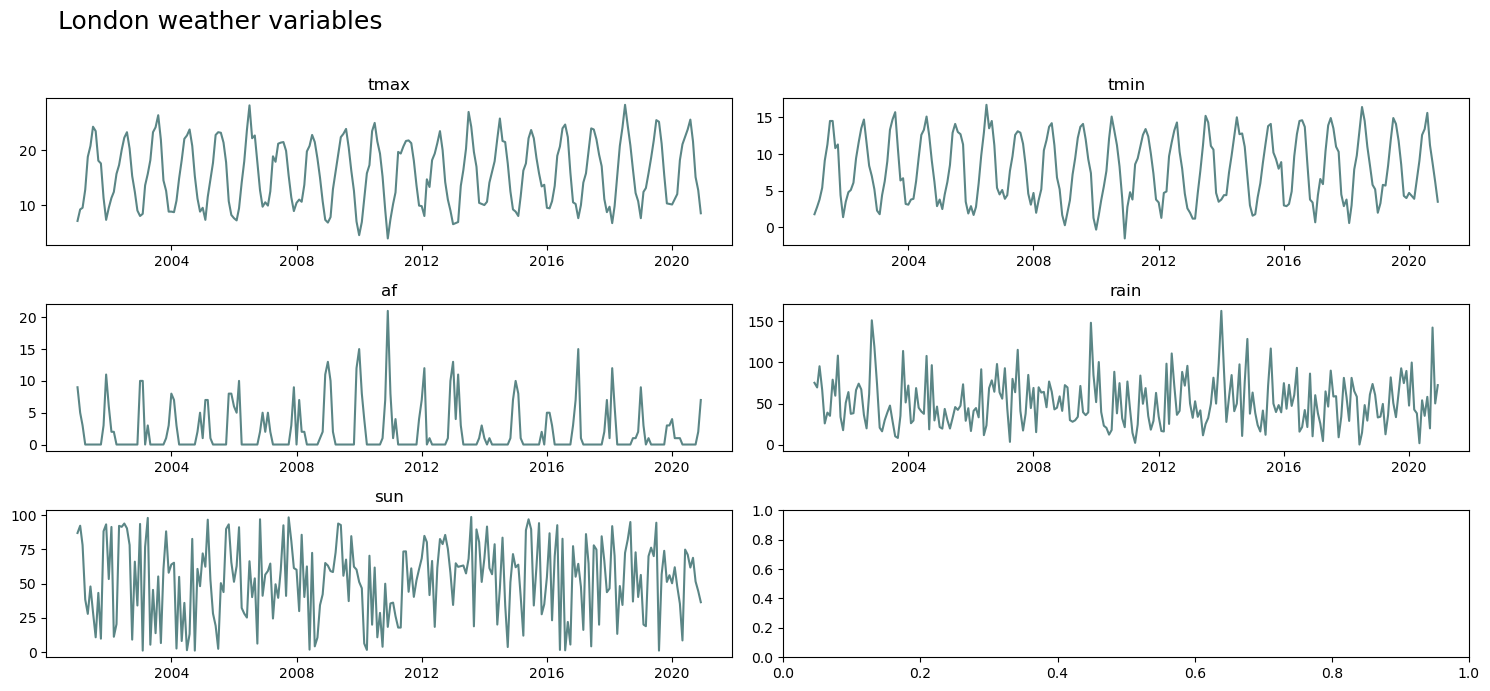

In [18]:
# Exploring data visually
cols = df_london_weather.columns

fig, axs = plt.subplots(3,2, figsize=(15,7))

for col, ax in zip(cols, axs.ravel()):
    ax.plot(df_london_weather[col], color='#5b8686')
    ax.set_title(f'{col}')

fig.suptitle('London weather variables\n', fontsize=18, x=0.15)
plt.tight_layout()
plt.show()

__COMMENT:__ Insights from first look at the data:

- Obvious seasonality for the temperatures variables which is of course not surprising.
- Frost: a peak in 2011 and drops in 2014 / 2016 / 2020
- Rain: pretty different over the months with no clear pattern, however we can see peaks in 2003, 2010, 2014 and 2020
- Sun: pretty different over the months with no clear pattern too

### Preprocess D3

In [19]:
# Passing date column to datetime
london_AQ_W['date'] = pd.to_datetime(london_AQ_W['date'])

# Dropping columns we won't be using
london_AQ_W = london_AQ_W.drop(columns=['code', 'NOXasNO2', 'site'])

In [20]:
# Check for duplicates
london_AQ_W .duplicated().sum()

0

In [21]:
# Set Date as index
london_AQ_W = london_AQ_W.set_index('date')

# Info for remaining columns
london_AQ_W.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175320 entries, 2001-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   O3      166103 non-null  float64
 1   NO2     170727 non-null  float64
 2   SO2     165304 non-null  float64
 3   CO      162747 non-null  float64
 4   PM10    164878 non-null  float64
dtypes: float64(5)
memory usage: 8.0 MB


In [22]:
london_AQ_W.describe()

,O3,NO2,SO2,CO,PM10
count,166103.000000,170727.000000,165304.000000,162747.000000,164878.000000
mean,17.182022,92.500818,7.475406,0.753649,34.272568
std,16.725605,48.679070,6.281302,0.650823,20.515758
min,-2.000000,2.000000,-0.833840,0.000000,-3.000000
25%,4.000000,56.249100,3.000000,0.300000,19.800000
50%,11.624950,84.000000,5.208050,0.600000,30.000000
75%,24.447330,120.000000,11.000000,0.900000,44.300000
max,156.462880,403.000000,136.000000,22.900000,707.000000


In [23]:
# Get full_index and make sure we don't have any date missing
full_index = pd.date_range(start='2001-01-01 00:00:00', end='2020-12-31 23:00:00', freq='h')
diff_month = len(full_index.difference(london_AQ_W.index))
print(f'We have a difference of {diff_month} data entries over 20 years')

We have a difference of 0 data entries over 20 years


In [24]:
# Check if we have missing values
london_AQ_W.isna().sum()

O3       9217
NO2      4593
SO2     10016
CO      12573
PM10    10442
dtype: int64

In [25]:
# See where the missing values are located
# fig = px.imshow(london_AQ_W.isna().T, color_continuous_scale=['beige', 'black'], height=350, width=1100)
# fig.update_layout(coloraxis_showscale=False)
# fig.show()

## Image pasted here, in the interest of the file weight

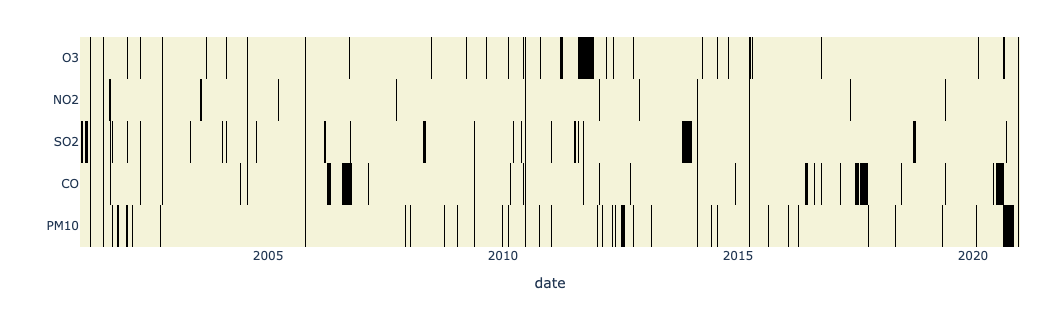

__COMMENT:__ 

- Black = missing values
- Beige = Existing values

As we have missing values spread across the timeline, we will use a forward fill.

In [96]:
# Fill missing values
london_AQ_W = london_AQ_W.fillna(method='ffill')

# Sanity check
# fig = px.imshow(london_AQ_W.isna().T, color_continuous_scale=['beige', 'black'], height=350, width=1100)
# fig.update_layout(coloraxis_showscale=False)
# fig.show()

## Image pasted here in the interest of file weight

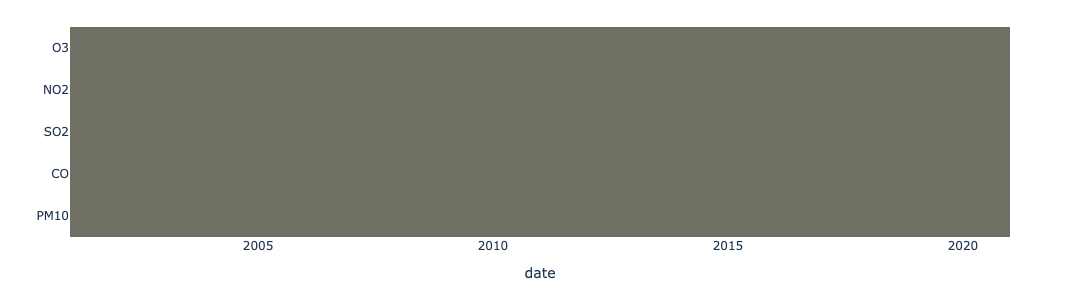

In [27]:
# Resample
london_AQ_W = london_AQ_W.reset_index()
london_AQ_W = london_AQ_W.resample('MS', on='date').mean()
london_AQ_W.head()

,O3,NO2,SO2,CO,PM10
date,,,,,
2001-01-01,7.215054,85.311828,12.530914,2.214113,49.475806
2001-02-01,12.074405,90.629464,14.056548,1.972917,45.086310
2001-03-01,15.688172,91.723118,11.280914,1.826882,44.403226
2001-04-01,23.625000,87.854167,9.719444,1.722361,38.877778
2001-05-01,29.263441,76.803763,8.352151,1.324866,33.419355


In [28]:
# Drop information out of time range compared to D1 (2001-2020)
london_AQ_W.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2001-01-01 to 2020-12-01
Freq: MS
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   O3      240 non-null    float64
 1   NO2     240 non-null    float64
 2   SO2     240 non-null    float64
 3   CO      240 non-null    float64
 4   PM10    240 non-null    float64
dtypes: float64(5)
memory usage: 11.2 KB


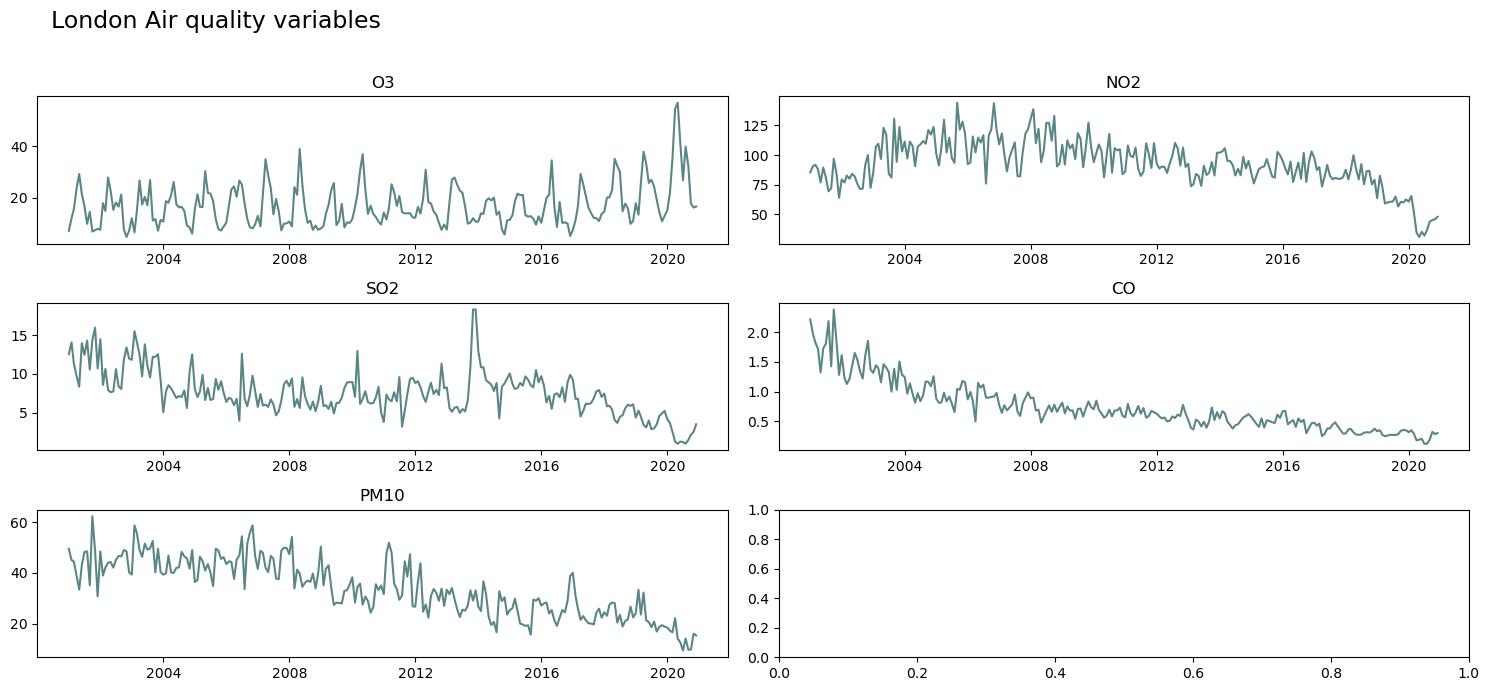

In [29]:
# Exploring data visually
cols = london_AQ_W.columns

fig, axs = plt.subplots(3,2, figsize=(15,7))

for col, ax in zip(cols, axs.ravel()):
    ax.plot(london_AQ_W[col], color='#5b8686')
    ax.set_title(f'{col}')

fig.suptitle('London Air quality variables \n', fontsize=17, x=0.15)
plt.tight_layout()
plt.show()

__COMMENT:__ Some insights for the pollutants observed here (from https://www.londonair.org.uk/LondonAir/guide/WhatIsPollution.aspx)

- O3: _'Almost no ozone is directly emitted by human activities, but it is __normally formed when other pollutants, including nitrogen dioxide, react in sunlight__. Therefore, on sunny days in polluted air concentrations of ozone can increase leading, in severe cases, to summertime "smog".'_

=> Clear seasonality (which is most likely linked to temperatures) and an upward trend with a sharp slope over the 3 last years.

- NO2: _'__Road transport__ is estimated to be responsible for about 50% of total emissions of nitrogen oxides'_

=> No evident seasonality here, downward trend over the years starting in 2008 and a sharp drop in 2020. This might be linked to the Low Emission Zone policies introduced in London in 2008 and 2019. The 2020 drop is most likely linked to the pandemic where a lot of people worked from home.

- SO2: _'Produced when a material, or fuel, containing sulphur is burned. In the UK the major contributors are __coal and oil burning by industry__ such as power stations and refineries'_

=> No seasonality, downward trend and a peak in 2014. Sharp decline after 2016

- CO: _'produced by incomplete combustion of fuel (...) It is estimated that __road transport__ is responsible for almost 90% of all carbon monoxide emissions in the UK'_

=> Constant downward trend over the years with no seasonality. 

- PM10: _'complex group of pollutants that vary in size, shape, composition and origin. (...) Particles originating from __road traffic__ include carbon emissions from engines, small bits of metal and rubber from engine wear and braking as well as dust from road surfaces. Others include material from __building and industry as well as wind-blown dust, sea salt, pollens and soil particles__'_

=> Downward trend as well, but less linear compared to CO, with higher waves 

### Full Dataset

In [30]:
# Merge D1 / D2
full_df = pd.merge(Sightings_Surveys['Butterflies_per_Survey'], df_london_weather.reset_index(), left_index=True, right_index=True, how='left')

# Merge D1-D2 / D3
full_df = pd.merge(full_df, london_AQ_W.reset_index(), left_index=True, right_index=True, how='left')

# Drop redundant columns
full_df = full_df.drop(columns=['date']).set_index('Year_Month')

# Sanity Check
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2001-01-01 to 2020-12-01
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Butterflies_per_Survey  240 non-null    float64
 1   tmax                    240 non-null    float64
 2   tmin                    240 non-null    float64
 3   af                      240 non-null    int64  
 4   rain                    240 non-null    float64
 5   sun                     240 non-null    float64
 6   O3                      240 non-null    float64
 7   NO2                     240 non-null    float64
 8   SO2                     240 non-null    float64
 9   CO                      240 non-null    float64
 10  PM10                    240 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 22.5 KB


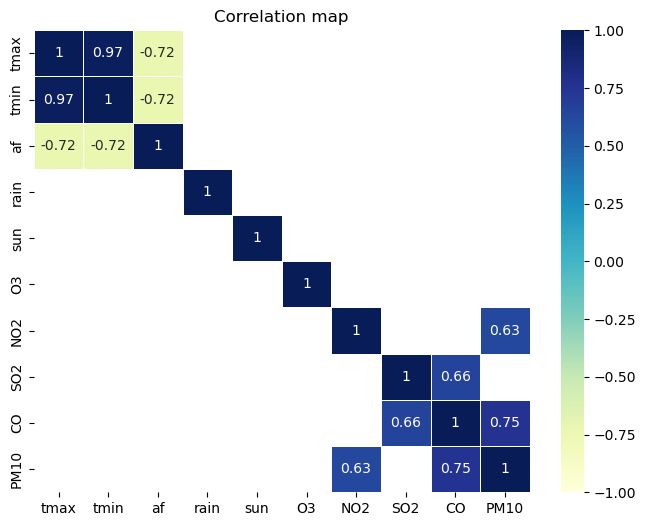

In [31]:
# Checking for collinearity amongst the independant variables
full_df_ind = full_df.drop(columns=['Butterflies_per_Survey'])

# Displaying only strong correlations above 0.6 or below -0.6
Corr = full_df_ind.corr()
Corr_1 = np.squeeze(np.asarray(Corr))
mask = np.zeros(Corr.shape)

for i in range(len(Corr)):
    for j in range(len(Corr)):
        if ((Corr_1[i][j] > -0.6) & (Corr_1[i][j] < 0.6)):
            mask[i][j] = 1

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(Corr, vmin = -1, vmax = 1, cmap = 'YlGnBu', annot = True, mask = mask, linewidth=0.5)
plt.title('Correlation map')
plt.show()

__COMMENT:__ 

- tmax and tmin have a very strong correlation, we will drop one of them
- Other variables seem to have a somewhat strong correlation as well:
    - af and tmax/tmin
    - PM10 and NO2/CO

I will drop tmin and keep the rest for now. At this stage it is a bit early to drop on or the other in the context of the target variable as the number of lags might have an impact on the strength of the relationship with `Butterflies_per_Survey`.

In [32]:
# Prep dataset
full_df2 = full_df.drop(columns=['tmin'])

# Prep for model - Renaming columns
full_df_trend = full_df2.rename(columns={'Butterflies_per_Survey':'y'})

In [33]:
full_df_trend.columns

Index(['y', 'tmax', 'af', 'rain', 'sun', 'O3', 'NO2', 'SO2', 'CO', 'PM10'], dtype='object')

__COMMENT:__ The idea here is to work with trends only (not the seasonality, not the residuals) to better understand the impact of external factors on the butterflies, regardless of seasonality:

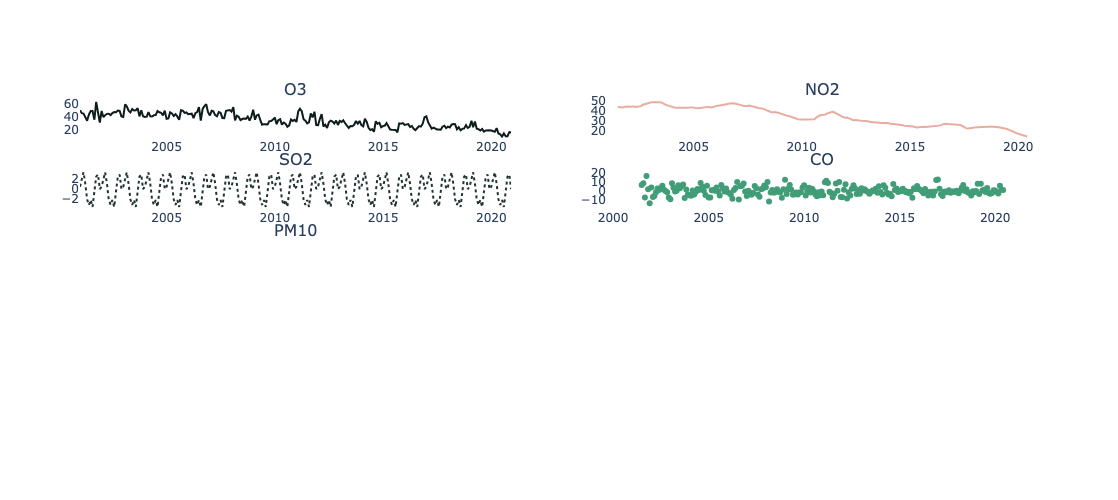

In [34]:
# Extract trends
cols_multi = full_df2.columns

for col in cols_multi:
    full_df_trend[col] = full_df2[col]
    
    decomposition = tsa.seasonal_decompose(full_df2[col], model='additive')
    full_df_trend[f'Trend_{col}'] = decomposition.trend
    full_df_trend[f'Seasonal_{col}'] = decomposition.seasonal
    full_df_trend[f'Residuals_{col}'] = decomposition.resid

# Plot
# cols = [f'Total {col}', f'Trend {col}', f'Seasonal {col}', f'Residuals {col}']
fig = make_subplots(rows=5, cols=2, subplot_titles=cols)

fig.add_trace(go.Scatter(x=full_df_trend.index, y=full_df_trend[col], line=dict(color='#0E1D1C')), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=full_df_trend.index, y=full_df_trend[f'Trend_{col}'], line=dict(color='#EBACA0')), 
              row=1, col=2)
fig.add_trace(go.Scatter(x=full_df_trend.index, y=full_df_trend[f'Seasonal_{col}'], line=dict(color='#233333'), line_dash='dot'), 
              row=2, col=1)
fig.add_trace(go.Scatter(x=full_df_trend.index, y=full_df_trend[f'Residuals_{col}'], mode='markers', line=dict(color='#419D78')), 
              row=2, col=2)

fig.update_layout(height=500, width=1150, showlegend=False, plot_bgcolor='white')
fig.show()

In [35]:
# Keep only "Trend_" columns
full_df_trend_only = full_df_trend.loc[:, ['Trend_' in col for col in full_df_trend.columns]]

# Drop NA
full_df_trend_only = full_df_trend_only.dropna()

# Prep dataset for Prophet input
full_df_trend_only = full_df_trend_only.reset_index().rename(columns={'Trend_Butterflies_per_Survey':'y', 'Year_Month':'ds'})

In [36]:
full_df_trend_only.head()

,ds,y,Trend_tmax,Trend_af,Trend_rain,Trend_sun,Trend_O3,Trend_NO2,Trend_SO2,Trend_CO,Trend_PM10
0,2001-07-01,6.272975,15.125000,2.458333,57.766667,52.5000,14.429326,82.194727,12.426427,1.785212,43.963711
1,2001-08-01,6.272975,15.312500,2.208333,56.525000,51.0625,14.690943,81.368008,12.278413,1.729596,43.664462
2,2001-09-01,6.272975,15.520833,2.041667,53.887500,48.2375,14.903164,80.410073,12.022649,1.669987,43.312402
3,2001-10-01,6.508350,15.762500,2.000000,50.312500,44.7000,15.048934,79.703406,11.919621,1.619745,43.430418
4,2001-11-01,6.762004,15.820833,2.000000,50.825000,46.6250,14.952657,79.681384,11.813849,1.602970,44.096205


In [37]:
full_df_trend_only.shape

(228, 11)

# Def Functions

## Eval

In [38]:
# Evaluation - Defining a function to calculate the Mean Absolute Percentage Error (will serve to evaluate scores across models)
def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Calculate the mean absolute percentage error. 
    Find the prediction error and devide by the true value, then average.
    """
    
    absolute_percentage_error = []

    for x, y in zip(true_values, predicted_values):
        error = x - y
        
        # Some true values in our dataset are = to 0 (months where there are no sightings), this is to avoid errors due to dividing by 0
        if x == 0:
            absolute_percentage_error.append(0)
        else: absolute_percentage_error.append(np.abs(error/x))

    mape = np.mean(absolute_percentage_error) * 100

    return mape

In [39]:
# Evaluation - Defining a function to calculate difference between MAPE train and MAPE test
def Diff_MAPE_calculation(train_mape, test_mape):
    return test_mape - train_mape

## Univariate

In [40]:
# Defining a function to find best parameters in univariate Prophet model
def uni_params_prophet(df, value_seasonality, value_changepoint):
    value_s_list = []
    value_c_list = []
    MAPE_train_prophet = []
    MAPE_test_prophet = []
    MAPE_diff_prophet = []
    
    for value_s in value_seasonality:
        for value_c in value_changepoint:
            model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, holidays=None, 
                            seasonality_prior_scale=value_s, changepoint_prior_scale=value_c)
    
            # Train/test Split - Defining % of data points in the test sets (25%)
            nobs = int(len(df)*0.70)
            
            # Creating train and test sets
            train = df.iloc[:nobs,:]
            test = df.iloc[nobs:,:]
            
            # Fit the Model
            model.fit(train)
    
            # Model predictions
            future = model.make_future_dataframe(periods=len(test), freq='MS')
            forecast = model.predict(future)
    
            # Make sure no predictions is below 0 (not possible)
            forecast['yhat'] = np.where(forecast['yhat']<0, 0, forecast['yhat'])
    
            # Merge dataset and forecast
            observed_forecast = pd.merge(df, forecast, left_on='ds', right_on='ds', how='left')
    
            # Evaluation of all combinations
            train_mape = mean_absolute_percentage_error(observed_forecast.loc[:nobs,'y'], observed_forecast.loc[:nobs,'yhat'])
            test_mape = mean_absolute_percentage_error(observed_forecast.loc[nobs:,'y'], observed_forecast.loc[nobs:,'yhat'])
            Diff_MAPE = abs(Diff_MAPE_calculation(train_mape, test_mape))
            
            value_s_list.append(value_s)
            value_c_list.append(value_c)
            MAPE_train_prophet.append(train_mape)
            MAPE_test_prophet.append(test_mape)
            MAPE_diff_prophet.append(Diff_MAPE)
    
    # DF of score for all combinations 
    results = pd.DataFrame({'Value_s': value_s_list, 
                'Value_c': value_c_list, 
                'MAPE_train': MAPE_train_prophet, 
                'MAPE_test': MAPE_test_prophet, 
                'Diff_MAPE': MAPE_diff_prophet})

    # Finding best combinations
    min_test = results['MAPE_test'].min() 
    print(f"Minimum MAPE test value: {round(min_test,2)} \n")
    print(f"{results[results['MAPE_test'] == min_test]}\n")
    
    s = results.loc[results['MAPE_test'] == min_test,'Value_s'].tolist()
    print(f"seasonality_prior_scale value for minimum MAPE test: {s}")
    
    c = results.loc[results['MAPE_test'] == min_test,'Value_c'].tolist()
    print(f"changepoint_prior_scale value for minimum MAPE test: {c}")

In [41]:
# Def function to model and evaluate univariate Prophet model
def uni_prophet(df, s, c, title):
    # Instantiate the model
    model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, 
                    holidays=None, seasonality_prior_scale=s, changepoint_prior_scale=c)
    
    # Train/test Split - Defining % of data points in the test sets (25%)
    nobs = int(len(df)*0.70)
    
    # Creating train and test sets
    train = df.iloc[:nobs,:]
    print(f'Train set shape: {train.shape[0]} rows and {train.shape[1]} columns')
    
    test = df.iloc[nobs:,:]
    print(f'Test set shape: {test.shape[0]} rows and {test.shape[1]} columns')
    
    # Fit the Model
    model.fit(train)

    # Model predictions
    future = model.make_future_dataframe(periods=len(test), freq='MS')
    forecast = model.predict(future)
    
    # Make sure no predictions is below 0 (not possible)
    forecast['yhat'] = np.where(forecast['yhat']<0, 0, forecast['yhat'])
    
    # Merge dataset and forecast
    observed_forecast = pd.merge(df, forecast, left_on='ds', right_on='ds', how='left')
    
    # Add Order info for linear regression
    observed_forecast['Order'] = range(len(observed_forecast))
    
    # Get Trendline
    X = observed_forecast['Order']
    y = observed_forecast['yhat']
    Trendline = sm.OLS(y.values, sm.add_constant(X.values), missing='drop').fit()
    
    # Plotting True values and Predictions
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=observed_forecast.loc[:nobs,'ds'], 
                             y=observed_forecast.loc[:nobs,'y'], 
                             mode='lines', line=dict(color='#233333'), name='Train', opacity=0.3))
    fig.add_trace(go.Scatter(x=observed_forecast.loc[nobs:,'ds'], 
                             y=observed_forecast.loc[nobs:,'y'], 
                             mode='lines', line=dict(color='#EBACA0'), name='Test', opacity=0.3))
    fig.add_trace(go.Scatter(x=observed_forecast['ds'],
                             y=observed_forecast['yhat'], mode='lines', 
                             line_dash='dot', line=dict(color='#419D78'), name='Predictions'))
        
    fig.update_layout(yaxis_title='Butterflies per Survey', 
                      title=f'PROPHET univariate {title}',
                      width=1100, height=400, plot_bgcolor='white', showlegend=True)
    fig.show()
    print(f'Trendline predictions coeff: {round(Trendline.params[1],4)}')
    print('\n')
    
    # Evaluation MAPE
    train_mape = mean_absolute_percentage_error(observed_forecast.loc[:nobs,'y'], observed_forecast.loc[:nobs,'yhat'])
    test_mape = mean_absolute_percentage_error(observed_forecast.loc[nobs:,'y'], observed_forecast.loc[nobs:,'yhat'])
    Diff_MAPE = Diff_MAPE_calculation(train_mape, test_mape)
    
    print(f'Train MAPE on the difference: {round(train_mape, 2)}%')
    print(f'Test MAPE on the difference: {round(test_mape, 2)}%')
    print(f'Difference in accuracy between train and test sets: {round(Diff_MAPE, 2)}% \n')

In [42]:
# Def function to forecast using univariate Prophet model
def uni_prophet_forecast(df, s, c):
    # Instantiate the model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, 
                    holidays=None, seasonality_prior_scale=s, changepoint_prior_scale=c)
    
    # Train/test Split - Defining % of data points in the test sets (25%)
    nobs = int(len(df)*0.70)
    
    # Fit the Model
    model.fit(df)

    # Model predictions
    future = model.make_future_dataframe(periods=60, freq='MS')
    forecast = model.predict(future)
    
    # Make sure no predictions is below 0 (not possible)
    forecast['yhat'] = np.where(forecast['yhat']<0, 0, forecast['yhat'])
    
    # Merge dataset and forecast
    observed_forecast = pd.merge(df, forecast, left_on='ds', right_on='ds', how='right')
    
    # Add Order info for linear regression
    observed_forecast['Order'] = range(len(observed_forecast))
  
    # Create df with y and yhat values for multivariate predictions
    index_split = df_tmax_12.index[-1]
    observed_forecast = observed_forecast[['ds', 'y', 'yhat']]
    observed_forecast.loc[index_split:,'y'] = observed_forecast.loc[index_split:,'yhat']
    observed_forecast = observed_forecast['y'].to_list()
    return observed_forecast

## Multivariate

In [43]:
# Defining a function to find best parameters in multivariate Prophet model
def multi_params_prophet(df, value_seasonality, value_changepoint):
    value_s_list = []
    value_c_list = []
    MAPE_train_prophet = []
    MAPE_test_prophet = []
    MAPE_diff_prophet = []
    
    for value_s in value_seasonality:
        for value_c in value_changepoint:
            model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, holidays=None, 
                            seasonality_prior_scale=value_s, changepoint_prior_scale=value_c)
            
            # Add regressors (independant variables)
            for col in df.drop(columns=['y', 'ds']).columns:
                model.add_regressor(col)
    
            # Train/test Split - Defining % of data points in the test sets (30%)
            nobs = int(len(df)*0.70)
            
            # Creating train and test sets
            train = df.iloc[:nobs,:]
            test = df.iloc[nobs:,:]
            
            # Fit the Model
            model_fit = model.fit(train)
    
            # Model predictions
            future_multi = model_fit.make_future_dataframe(periods=len(test), freq='MS')
            full_future_multi = pd.merge(future_multi, df.drop(columns=['y']), left_on='ds', right_on='ds', how='left')
            forecast_multi = model_fit.predict(full_future_multi)
    
            # Make sure no predictions is below 0 (not possible)
            forecast_multi['yhat'] = np.where(forecast_multi['yhat']<0, 0, forecast_multi['yhat'])
    
            # Merge dataset and forecast
            observed_forecast = pd.merge(df, forecast_multi, left_on='ds', right_on='ds', how='left')
    
            # Evaluation for each c/s value
            train_mape = mean_absolute_percentage_error(observed_forecast.loc[:nobs,'y'], observed_forecast.loc[:nobs,'yhat'])
            test_mape = mean_absolute_percentage_error(observed_forecast.loc[nobs:,'y'], observed_forecast.loc[nobs:,'yhat'])
            Diff_MAPE = abs(Diff_MAPE_calculation(train_mape, test_mape))
            
            value_s_list.append(value_s)
            value_c_list.append(value_c)
            MAPE_train_prophet.append(train_mape)
            MAPE_test_prophet.append(test_mape)
            MAPE_diff_prophet.append(Diff_MAPE)

    # Evaluation grid and selection of best parameters
    results = pd.DataFrame({'Value_s': value_s_list, 
                'Value_c': value_c_list, 
                'MAPE_train': MAPE_train_prophet, 
                'MAPE_test': MAPE_test_prophet, 
                'Diff_MAPE': MAPE_diff_prophet})

    # Finding best value
    min_test = results['MAPE_test'].min() 
    print(f"Minimum MAPE test value: {round(min_test,2)} \n")
    print(f"{results[results['MAPE_test'] == min_test]}\n")
    
    s = results.loc[results['MAPE_test'] == min_test,'Value_s'].item()
    print(f"seasonality_prior_scale value for minimum MAPE test: {s}")
    
    c = results.loc[results['MAPE_test'] == min_test,'Value_c'].item()
    print(f"changepoint_prior_scale value for minimum MAPE test: {c}")

In [44]:
# Def function to model and evaluate multivariate Prophet model
def multi_prophet(df, s, c, title):
    # Instantiate the model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, 
                    holidays=None, seasonality_prior_scale=s, changepoint_prior_scale=c)
    
    # Add regressors (independant variables)
    for col in df.drop(columns=['y', 'ds']).columns:
        model.add_regressor(col)
    
    # Train/test Split - Defining % of data points in the test sets (30%)
    nobs = int(len(df)*0.70)
    
    # Creating train and test sets
    train = df.iloc[:nobs,:]
    print(f'Train set shape: {train.shape[0]} rows and {train.shape[1]} columns')
    
    test = df.iloc[nobs:,:]
    print(f'Test set shape: {test.shape[0]} rows and {test.shape[1]} columns')

    # Fit the Model
    prophet_fit_multi = model.fit(train)

    # Model predictions
    future_multi = model.make_future_dataframe(periods=len(test), freq='MS')
    full_future_multi = pd.merge(future_multi, df.drop(columns=['y']), left_on='ds', right_on='ds', how='left')
    forecast_multi = model.predict(full_future_multi)
    
    # Make sure no predictions is below 0 (not possible)
    forecast_multi['yhat'] = np.where(forecast_multi['yhat']<0, 0, forecast_multi['yhat'])
    
    # Merge dataset and forecast
    observed_forecast_prophet_multi = pd.merge(df, forecast_multi, left_on='ds', right_on='ds', how='left')
    
    # Add Order info for linear regression
    observed_forecast_prophet_multi['Order'] = range(len(observed_forecast_prophet_multi))
    
    #Get Trendline
    X = observed_forecast_prophet_multi['Order']
    y = observed_forecast_prophet_multi['yhat']
    Trendline = sm.OLS(y.values, sm.add_constant(X.values), missing='drop').fit()
    
    # Plotting True values and Predictions
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=observed_forecast_prophet_multi.loc[:nobs,'ds'], 
                             y=observed_forecast_prophet_multi.loc[:nobs,'y'], 
                             mode='lines', line=dict(color='#233333'), name='Train', opacity=0.3))
    fig.add_trace(go.Scatter(x=observed_forecast_prophet_multi.loc[nobs:,'ds'], 
                             y=observed_forecast_prophet_multi.loc[nobs:,'y'], 
                             mode='lines', line=dict(color='#EBACA0'), name='Test', opacity=0.3))
    fig.add_trace(go.Scatter(x=observed_forecast_prophet_multi['ds'],
                             y=observed_forecast_prophet_multi['yhat'], mode='lines', 
                             line_dash='dot', line=dict(color='#419D78'), name='Predictions'))
    

    fig.update_yaxes(range=[0, 12])
    fig.update_layout(yaxis_title='Butterflies per Survey', 
                      title=f'PROPHET multivariate {title}',
                      width=1100, height=500, plot_bgcolor='white', showlegend=True)
    fig.show()
    print(f'Trendline predictions coeff: {round(Trendline.params[1],4)}')
    print('\n')
    
    # Evaluation MAPE
    train_mape = mean_absolute_percentage_error(observed_forecast_prophet_multi.loc[:nobs,'y'], 
                                                observed_forecast_prophet_multi.loc[:nobs,'yhat'])
    test_mape = mean_absolute_percentage_error(observed_forecast_prophet_multi.loc[nobs:,'y'], 
                                               observed_forecast_prophet_multi.loc[nobs:,'yhat'])
    Diff_MAPE = Diff_MAPE_calculation(train_mape, test_mape)
    
    print(f'Train MAPE on the difference: {round(train_mape, 2)}%')
    print(f'Test MAPE on the difference: {round(test_mape, 2)}%')
    print(f'Difference in accuracy between train and test sets: {round(Diff_MAPE, 2)}% \n')

    # Plotting regressors coefs
    regressor_coef = regressor_coefficients(model)
    regressor_coef = regressor_coef.sort_values(by='coef', ascending=True)
    
    plt.figure(figsize=(15,5))
    plt.barh(regressor_coef['regressor'], regressor_coef['coef'], color='#233333')
    plt.title('Regressor coefficients')
    plt.show()

In [45]:
# Def function to model and evaluate multivariate Prophet model
def multi_prophet_forecast(df, s, c, title):
    # Instantiate the model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, 
                    holidays=None, seasonality_prior_scale=10, changepoint_prior_scale=1)
    
    # Set index
    df_index = df.set_index('ds').loc[:'2020-06-01',:].reset_index()
    
    # Add regressors (independant variables)
    for col in df_index.drop(columns=['y', 'ds']).columns:
        model.add_regressor(col)
    
    # Train/test Split - Defining % of data points in the test sets (30%)
    nobs = int(len(df_index)*0.70)
    
    # Creating train and test sets
    train = df_index.iloc[:nobs,:]
    print(f'Train set shape: {train.shape[0]} rows and {train.shape[1]} columns')
    
    test = df_index.iloc[nobs:,:]
    print(f'Test set shape: {test.shape[0]} rows and {test.shape[1]} columns')
    
    # Fit the Model
    prophet_fit_multi = model.fit(train)
    
    ###################### Model predictions on observed values ######################
    future_multi = model.make_future_dataframe(periods=len(test), freq='MS')
    full_future_multi = pd.merge(future_multi, df_index.drop(columns=['y']), left_on='ds', right_on='ds', how='left')
    forecast_multi = model.predict(full_future_multi)
    
    # Make sure no predictions is below 0 (not possible)
    forecast_multi['yhat'] = np.where(forecast_multi['yhat']<0, 0, forecast_multi['yhat'])
    
    # Merge dataset and forecast
    observed_forecast1 = pd.merge(df_index, forecast_multi, left_on='ds', right_on='ds', how='left')
    
    ###################### Model predictions on future values ######################
    future_multi = model.make_future_dataframe(periods=len(test)+60, freq='MS')
    full_future_multi = pd.merge(future_multi, df.drop(columns=['y']), left_on='ds', right_on='ds', how='left')
    forecast_multi = model.predict(full_future_multi)
    
    # Make sure no predictions is below 0 (not possible)
    forecast_multi['yhat'] = np.where(forecast_multi['yhat']<0, 0, forecast_multi['yhat'])
    
    # Merge dataset and forecast
    observed_forecast2 = pd.merge(df, forecast_multi, left_on='ds', right_on='ds', how='left')
    
    ###################### Plot ######################
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=observed_forecast1.loc[:nobs,'ds'], 
                             y=observed_forecast1.loc[:nobs,'y'], 
                             mode='lines', line=dict(color='#233333'), name='Train', opacity=0.3))
    fig.add_trace(go.Scatter(x=observed_forecast1.loc[nobs:,'ds'], 
                             y=observed_forecast1.loc[nobs:,'y'], 
                             mode='lines', line=dict(color='#EBACA0'), name='Test', opacity=0.3))
    fig.add_trace(go.Scatter(x=observed_forecast1['ds'],
                             y=observed_forecast1['yhat'], mode='lines', 
                             line_dash='dot', line=dict(color='#419D78'), name='Predictions'))
    fig.add_trace(go.Scatter(x=observed_forecast2.loc['2020-06-01':,'ds'],
                             y=observed_forecast2.loc['2020-06-01':, 'yhat'], mode='lines', 
                             line_dash='dash', line=dict(color='#115869'), name='Forecasts'))
    
    
    fig.update_yaxes(range=[0, 12])
    fig.update_layout(yaxis_title='Butterflies per Survey', title=f'PROPHET multivariate {title}',
                      width=1100, height=400, plot_bgcolor='white', showlegend=True)
    fig.show()

# Models
## Model 1 - ARIMA

### Preprocess for model

__COMMENT:__ Splitting the dataset 75/25% (aka 75% of all the rows = 180 datapoints), in chronological order.

In [46]:
# Defining % of data points in the test sets (25%)
nobs = int(len(full_df_trend_only) - len(full_df_trend_only)*0.25)

# Creating train and test sets
train = full_df_trend_only['y'].iloc[:nobs]
print(f'Train set shape: {train.shape[0]} rows')

test = full_df_trend_only['y'].iloc[nobs:]
print(f'Test set shape: {test.shape[0]} rows')

Train set shape: 171 rows
Test set shape: 57 rows


__COMMENT:__ need to assess the best following parameters:

- p: Trend autoregression order - found with PACF plot (points above the blue zone)
- d: Trend difference order - as we have a seasonality here, the differencing done to get a stationary timeline should be enough 
- q: Trend moving average order - found with ACF plot (see sharp drop in ACF plot)

The timeline will also need to be stationary to increase the model's performance.

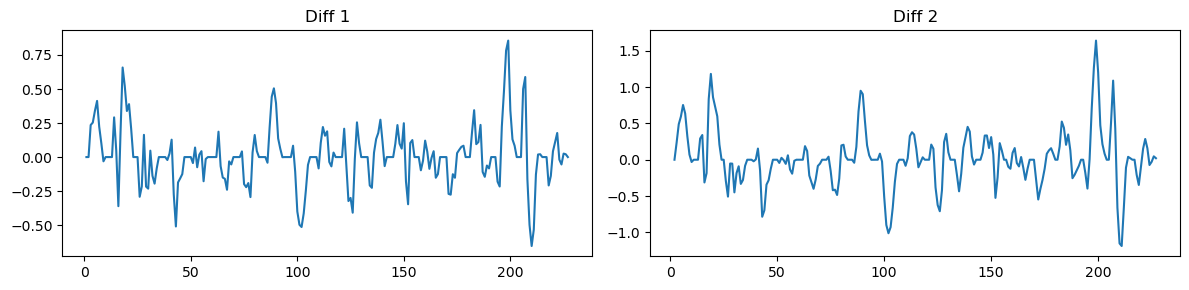

In [47]:
# Finding d parameter
full_df_trend_only['Diff_1'] = full_df_trend_only['y'].diff(1)
full_df_trend_only['Diff_2'] = full_df_trend_only['y'].diff(2)

# Plot
plt.subplots(1, 2, figsize=(12,3))

plt.subplot(1,2,1)
plt.plot(full_df_trend_only['Diff_1'])
plt.title('Diff 1')

plt.subplot(1,2,2)
plt.plot(full_df_trend_only['Diff_2'])
plt.title('Diff 2')

plt.tight_layout()
plt.show()

In [48]:
# Testing stationarity
DickeyFullerTest_12 = adfuller(full_df_trend_only['Diff_1'].dropna())
print('Statistic Test : ', round(DickeyFullerTest_12[0], 2))
print('p-value : ', round(DickeyFullerTest_12[1],4))

Statistic Test :  -3.99
p-value :  0.0014


__COMMENT:__ The data is now stationary, diff 1 is enough.

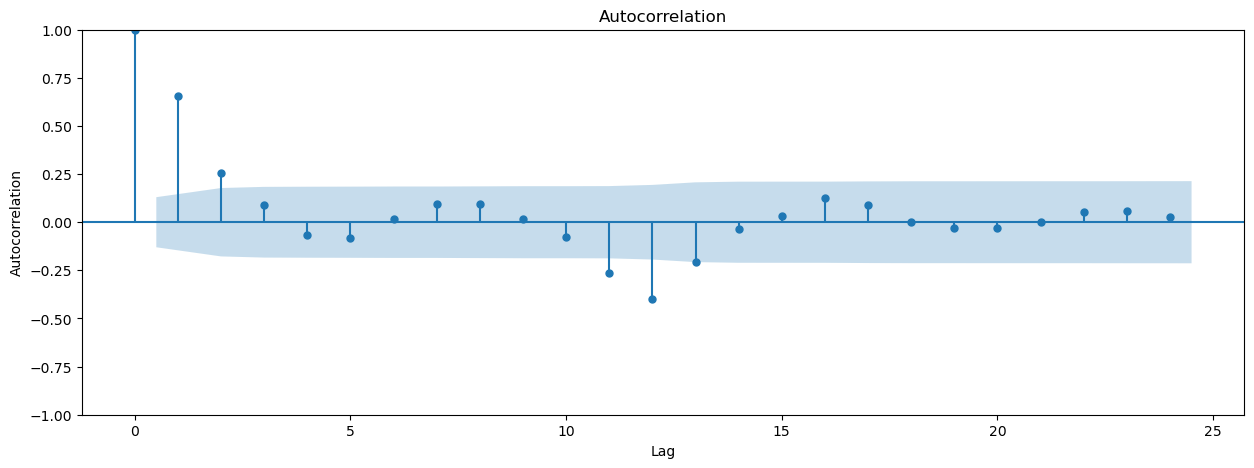

In [49]:
# Finding q
plt.figure(figsize=(15, 5))
plot_acf(full_df_trend_only['Diff_1'].dropna(), lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

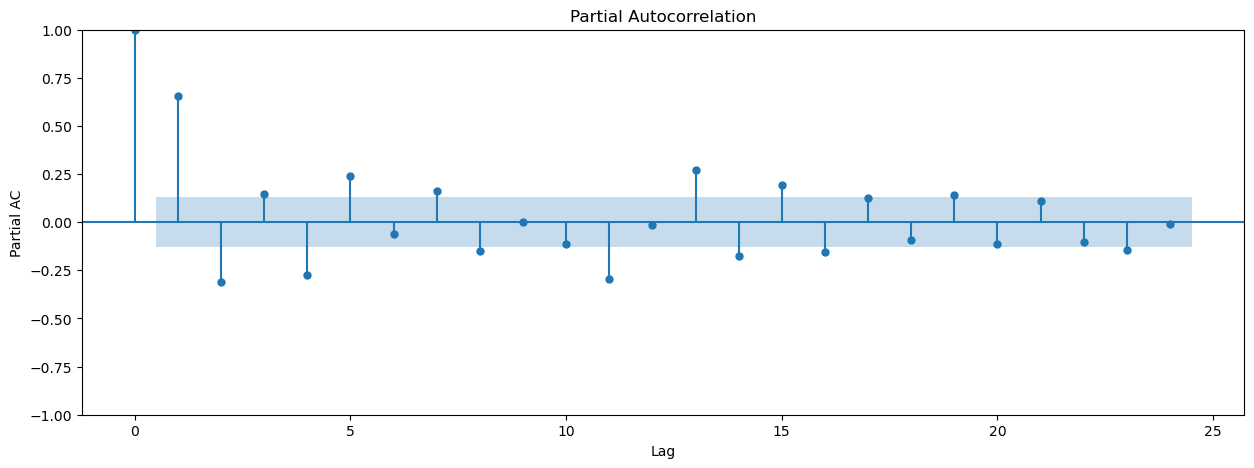

In [50]:
# Finding p
plt.figure(figsize=(15, 5))
plot_pacf(full_df_trend_only['Diff_1'].dropna(), lags=24, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

__COMMENT:__ Given the ACF and PCAF plots above we can infer that the best parameters would be:

- p: 4
- d: 1
- q: 2
- m: 12 for the yearly seasonality

To confirm this intuition, we will also run an auto_arima function which will look through the best combos possible and select the one with the lowest AIC.

In [51]:
model_test = pm.auto_arima(train.dropna(), trace = True)
model_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.511, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-171.185, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.508, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-177.688, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-184.519, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-199.308, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-202.010, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-204.008, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-201.308, Time=0.01 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  171
Model:               SARIMAX(5, 1, 0)   Log Likelihood                 108.004
Date:                Fri, 26 Apr 2024   AIC                           -204.008
Time:                        09:53:20   BIC                           -185.193
Sample:                             0   HQIC                          -196.373
                                - 171                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9357      0.062     15.185      0.000       0.815       1.057
ar.L2         -0.5964      0.093     -6.390      0.000      -0.779      -0.413
ar.L3          0.5633      0.107      5.259      0.000       0.353       0.773
ar.L4         -0.4526      0.135     -3.354      0.001      -0.717      -0.188
ar.L5          0.1663      0.116      1.439      0.150      -0.060       0.393
sigma2         0.0163      0.002     10.371      0.000       0.013       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 5.41
Prob(Q):                              0.88   Prob(JB):                         0.07
Heteroskedasticity (H):               0.59   Skew:                            -0.01
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

__COMMENT:__ The results are different from our intuition, however, the AIC for 4,1,2 values are not detailed here (inf). I will proceed with the parameters from auto_arima.

### Model and evaluation

In [52]:
# Model
arima = SARIMAX(train.dropna(), order=(5,1,1), trend='c')
arima_fit = arima.fit(disp=0)
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  171
Model:               SARIMAX(5, 1, 1)   Log Likelihood                 116.722
Date:                Fri, 26 Apr 2024   AIC                           -217.444
Time:                        09:53:20   BIC                           -192.358
Sample:                             0   HQIC                          -207.265
                                - 171                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0032      0.020      0.160      0.873      -0.036       0.042
ar.L1          0.0544      0.069      0.794      0.427      -0.080       0.189
ar.L2          0.1722      0.076      2.262      0.024       0.023       0.321
ar.L3          0.1106      0.078      1.416      0.157      -0.043       0.264
ar.L4         -0.0264      0.099     -0.268      0.789      -0.220       0.167
ar.L5         -0.1413      0.138     -1.027      0.305      -0.411       0.128
ma.L1          0.9924      0.120      8.286      0.000       0.758       1.227
sigma2         0.0143      0.002      7.445      0.000       0.011       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                15.70
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.12
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

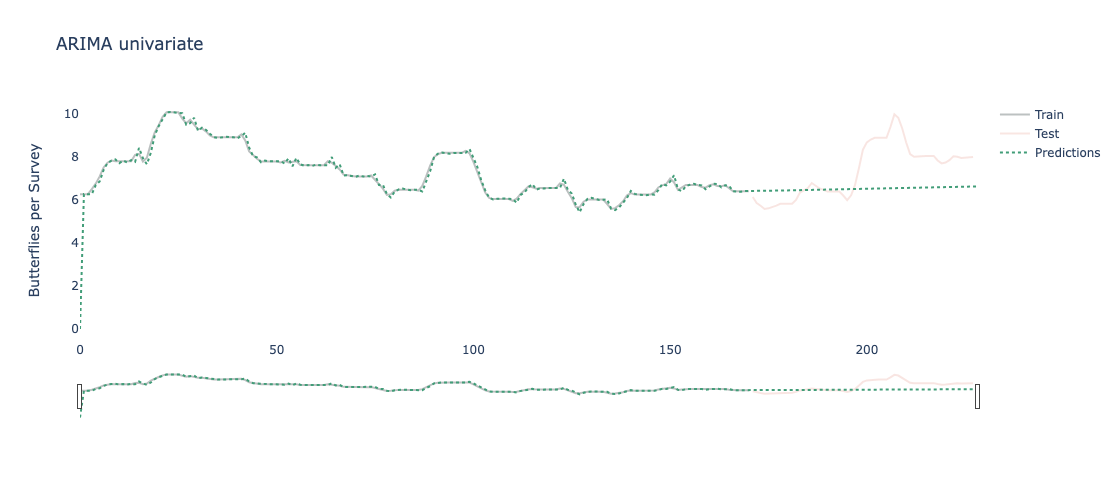

Trendline predictions coeff: -0.0092


Train MAPE on the difference: 1.72%
Test MAPE on the difference: 14.15%
Difference in accuracy between train and test sets: 12.43%


In [53]:
# Predicting with SARIMA model
predictions_arima = arima_fit.predict(start=0, end=len(train.dropna())+len(test.dropna()))

# Add Order info for linear regression
predictions_arima_df = pd.DataFrame(predictions_arima) 
predictions_arima_df['Order'] = range(len(predictions_arima_df))

# Make sure no predictions are below 0 (not possible)
predictions_arima_df['predicted_mean'] = np.where(predictions_arima_df['predicted_mean'] < 0, 0, predictions_arima_df['predicted_mean'])

#Get Trendline
X = predictions_arima_df['Order']
y = predictions_arima_df['predicted_mean']
Trendline = sm.OLS(y.values, sm.add_constant(X.values), missing='drop').fit()

# Plotting True values and Predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.dropna().index, y=train.dropna(), mode='lines', line=dict(color='#233333'), name='Train', opacity=0.3))
fig.add_trace(go.Scatter(x=test.dropna().index, y=test.dropna(), mode='lines', line=dict(color='#EBACA0'), name='Test', opacity=0.3))
fig.add_trace(go.Scatter(x=predictions_arima_df.index, y=predictions_arima_df['predicted_mean'], mode='lines', line_dash='dot', 
                         line=dict(color='#419D78'), name='Predictions'))

fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(yaxis_title='Butterflies per Survey',
                  title='ARIMA univariate',
                  width=1100, height=500, plot_bgcolor='white', showlegend=True)
fig.show()
print(f'Trendline predictions coeff: {round(Trendline.params[1],4)}')
print('\n')

# Evaluation - Models Results
split_index = pd.DataFrame(test).index[0]
train_mape = mean_absolute_percentage_error(train.dropna(), predictions_arima_df.loc[:split_index,'predicted_mean'])
test_mape = mean_absolute_percentage_error(test.dropna(), predictions_arima_df.loc[split_index:,'predicted_mean'])
Diff_MAPE = Diff_MAPE_calculation(train_mape, test_mape)

print(f'Train MAPE on the difference: {round(train_mape, 2)}%')
print(f'Test MAPE on the difference: {round(test_mape, 2)}%')
print(f'Difference in accuracy between train and test sets: {round(Diff_MAPE, 2)}%')

__COMMENT:__ The predictions on the train set are very good, however the model failed completely to pick up any sort of trend of variations after the train set. I will now try a univariate Prophet model.

## Model 2 - Prophet univariate

In [54]:
################ PREPROCESS FOR MODEL ################
full_df_trend_only = full_df_trend_only.drop(columns=['Diff_1', 'Diff_2'])
df_prophet = full_df_trend_only[['ds', 'y']].dropna()

In [55]:
################ Finding Best Parameters ################
value_seasonality = [0.001, 0.01, 0.1, 1, 10, 100]
value_changepoint = [0.001, 0.01, 0.1, 1, 10, 100]

uni_params_prophet(df_prophet, value_seasonality, value_changepoint)

Minimum MAPE test value: 11.43 

    Value_s  Value_c  MAPE_train  MAPE_test  Diff_MAPE
2     0.001      0.1    5.242378   11.42972   6.187342
8     0.010      0.1    5.242378   11.42972   6.187342
14    0.100      0.1    5.242378   11.42972   6.187342
20    1.000      0.1    5.242378   11.42972   6.187342
26   10.000      0.1    5.242378   11.42972   6.187342
32  100.000      0.1    5.242378   11.42972   6.187342

seasonality_prior_scale value for minimum MAPE test: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
changepoint_prior_scale value for minimum MAPE test: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


Train set shape: 159 rows and 2 columns
Test set shape: 69 rows and 2 columns


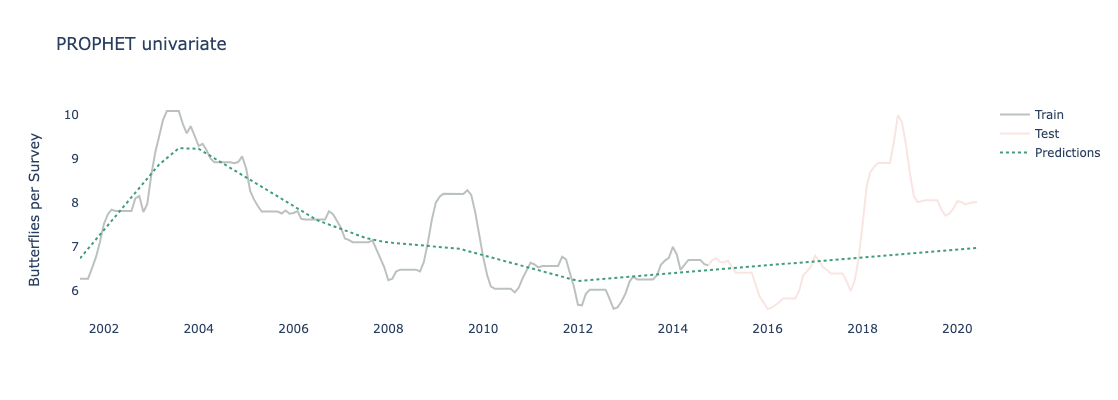

Trendline predictions coeff: -0.0088


Train MAPE on the difference: 5.24%
Test MAPE on the difference: 11.43%
Difference in accuracy between train and test sets: 6.19% 



In [56]:
################ Model and evalutation ################
uni_prophet(df_prophet, 0.001, 0.1, '')

__COMMENT:__ The model is better than the ARIMA one (better MAPE score on the test set) and follows a general trend downward up until 2012 and then upward as the observed values, however we do not see any sort of variations in the predictions. Let's try to improve the accuracy with external factors.

## Model 3 - Prophet multi - With lags

__COMMENT:__ For this model, I try to improve the predictions with external factors (weather and air quality data).

I have also chosen to add a 12 month lag to try capturing the impact of external factors on the butterflies after a year. The life cycle of the butterflies varies from a few weeks to several months depending on the species, and because there are several species in London (34), I chose to generalize to the 1-year-period.

In [57]:
################ PREPROCESS FOR MODEL ################
# Prep dataset
full_df_diff = full_df_trend_only.copy()

# Diff for independant variables: observe impact on butterfly population 12 months after observed values
full_df_diff = full_df_diff.drop(columns=['y']).copy()
col_weather = ['Trend_tmax', 'Trend_af', 'Trend_rain', 'Trend_sun']
col_airquality = ['Trend_O3', 'Trend_NO2', 'Trend_SO2', 'Trend_CO', 'Trend_PM10']

for col in col_weather:
    full_df_diff[f'Lag_{col}12'] = full_df_diff[col].shift(periods=12)

for col in col_airquality:
    full_df_diff[f'Lag_{col}12'] = full_df_diff[col].shift(periods=12)

# Merge diff independant and dependant variable without differencing
full_df_diff = pd.merge(full_df_trend_only['y'], full_df_diff, left_index=True, right_index=True, how='left')

# Drop missing values after diff
full_df_diff = full_df_diff.dropna()

# Drop columns with no lags
full_df_diff = full_df_diff[['y', 'ds', 'Lag_Trend_tmax12', 'Lag_Trend_af12', 'Lag_Trend_rain12',
                                         'Lag_Trend_sun12', 'Lag_Trend_O312', 'Lag_Trend_NO212', 'Lag_Trend_SO212', 
                                         'Lag_Trend_CO12', 'Lag_Trend_PM1012']]

In [58]:
################ Finding Best Parameters ################
value_seasonality = [0.001, 0.01, 0.1, 1, 10, 100]
value_changepoint = [0.001, 0.01, 0.1, 1, 10, 100]

multi_params_prophet(full_df_diff, value_seasonality, value_changepoint)

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


Minimum MAPE test value: 19.88 

   Value_s  Value_c  MAPE_train  MAPE_test  Diff_MAPE
3    0.001      1.0    1.310354   19.88359  18.573235

seasonality_prior_scale value for minimum MAPE test: 0.001
changepoint_prior_scale value for minimum MAPE test: 1.0


Train set shape: 151 rows and 11 columns
Test set shape: 65 rows and 11 columns


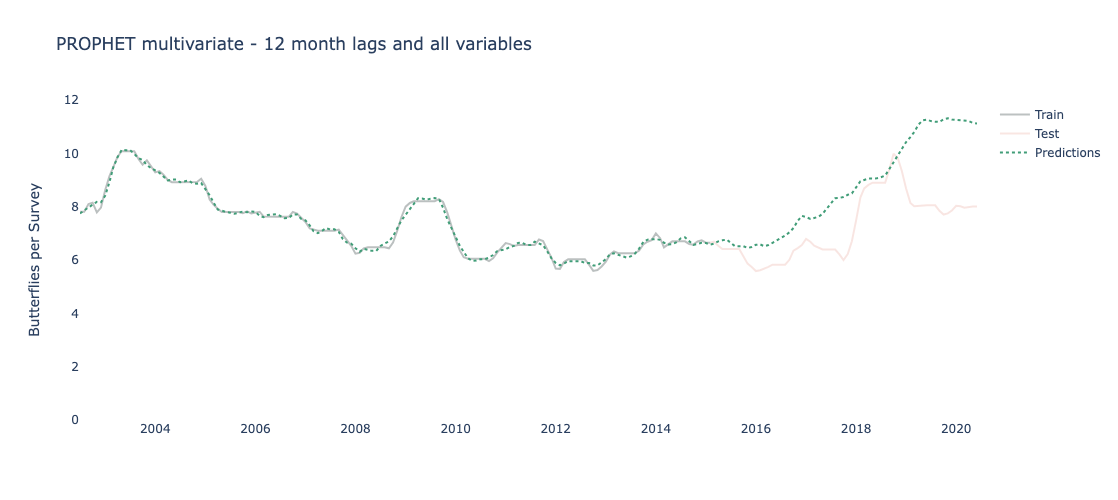

Trendline predictions coeff: 0.0032


Train MAPE on the difference: 1.31%
Test MAPE on the difference: 19.88%
Difference in accuracy between train and test sets: 18.57% 



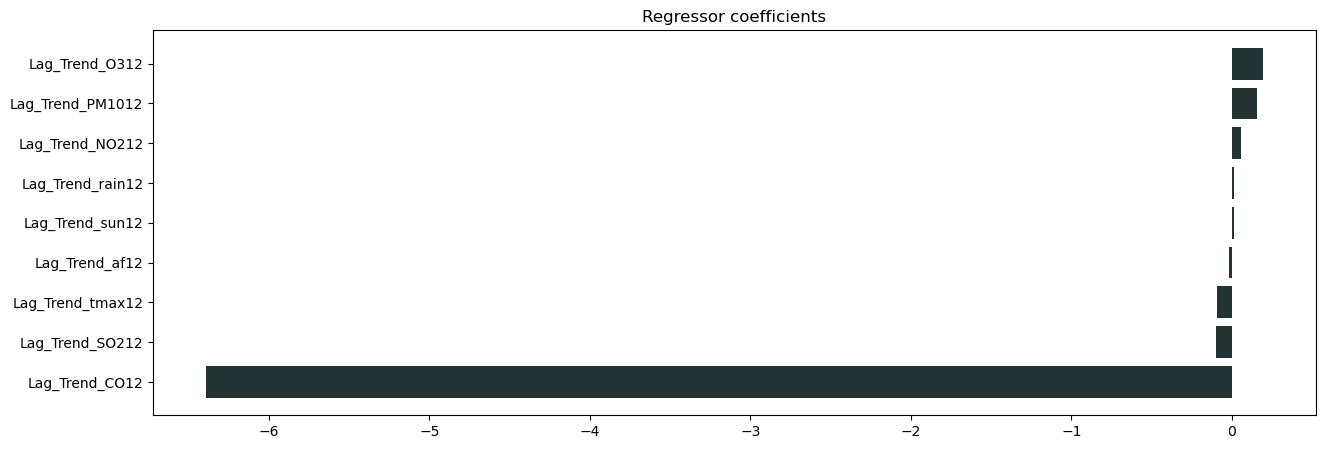

In [59]:
################ Model and evalutation ################
multi_prophet(full_df_diff, 0.001, 1, '- 12 month lags and all variables')

__COMMENT:__ The model has very good results on the train set but fails to follow the trend on the test set and shows very poor results there. I will try another approach in our next model:

## Model 4 - Prophet multi - Several lags and columns selection

__COMMENT__: Here, I try 2 different type of lags (12 and 24 months) along with a selection of variables, instead of feeding everything to the model

In [60]:
################ PREPROCESS FOR MODEL ################
# Prep dataset
full_df_multi_lags = full_df_trend_only.copy()

# Prep lags
for col in full_df_multi_lags.drop(columns=['y', 'ds']).columns:
    for i in range(12,25,12):
        full_df_multi_lags[f'Lag_{col}_{i}'] = full_df_multi_lags[col].shift(i)

# Drop NA
full_df_multi_lags = full_df_multi_lags.dropna()

# Drop columns with no lags
full_df_multi_lags = full_df_multi_lags[['ds', 'y', 
       'Lag_Trend_tmax_12', 'Lag_Trend_tmax_24', 'Lag_Trend_af_12',
       'Lag_Trend_af_24', 'Lag_Trend_rain_12', 'Lag_Trend_rain_24',
       'Lag_Trend_sun_12', 'Lag_Trend_sun_24', 'Lag_Trend_O3_12',
       'Lag_Trend_O3_24', 'Lag_Trend_NO2_12', 'Lag_Trend_NO2_24',
       'Lag_Trend_SO2_12', 'Lag_Trend_SO2_24', 'Lag_Trend_CO_12',
       'Lag_Trend_CO_24', 'Lag_Trend_PM10_12', 'Lag_Trend_PM10_24']]

In [61]:
full_df_multi_lags_list = ['ds', 'y']

for col in full_df_multi_lags.drop(columns=['ds', 'y']).columns:
    joh = coint_johansen(full_df_multi_lags[['y', col]], det_order=0, k_ar_diff=1)
    tracevalues = joh.lr1
    critical_values = joh.cvt
    diff = tracevalues[1] - critical_values[1, :]
    if (tracevalues[1] > critical_values[1, :]).all():
        print(f"{col}: cointegrated")
        full_df_multi_lags_list.append(col)
    else:
        print(f"{col} - ")

Lag_Trend_tmax_12: cointegrated
Lag_Trend_tmax_24: cointegrated
Lag_Trend_af_12: cointegrated
Lag_Trend_af_24: cointegrated
Lag_Trend_rain_12: cointegrated
Lag_Trend_rain_24: cointegrated
Lag_Trend_sun_12: cointegrated
Lag_Trend_sun_24: cointegrated
Lag_Trend_O3_12 - 
Lag_Trend_O3_24: cointegrated
Lag_Trend_NO2_12 - 
Lag_Trend_NO2_24 - 
Lag_Trend_SO2_12 - 
Lag_Trend_SO2_24: cointegrated
Lag_Trend_CO_12 - 
Lag_Trend_CO_24 - 
Lag_Trend_PM10_12 - 
Lag_Trend_PM10_24 - 


In [62]:
full_df_multi_lags = full_df_multi_lags.loc[:,full_df_multi_lags_list]

In [63]:
################ Finding Best Parameters ################
value_seasonality = [0.001, 0.01, 0.1, 1, 10, 100]
value_changepoint = [0.001, 0.01, 0.1, 1, 10, 100]

multi_params_prophet(full_df_multi_lags, value_seasonality, value_changepoint)

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


Minimum MAPE test value: 9.66 

   Value_s  Value_c  MAPE_train  MAPE_test  Diff_MAPE
9     0.01      1.0    1.244542   9.655408   8.410866

seasonality_prior_scale value for minimum MAPE test: 0.01
changepoint_prior_scale value for minimum MAPE test: 1.0


In [64]:
################ Model and evalutation ################
# multi_prophet(full_df_multi_lags, 0.01, 1, '- Lags and variables selection #1')

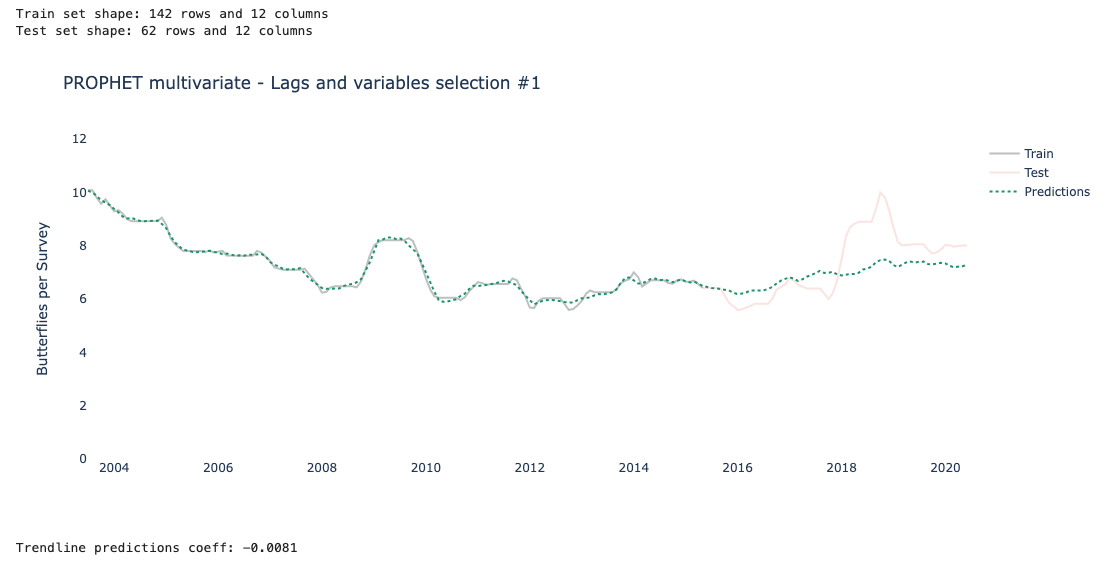
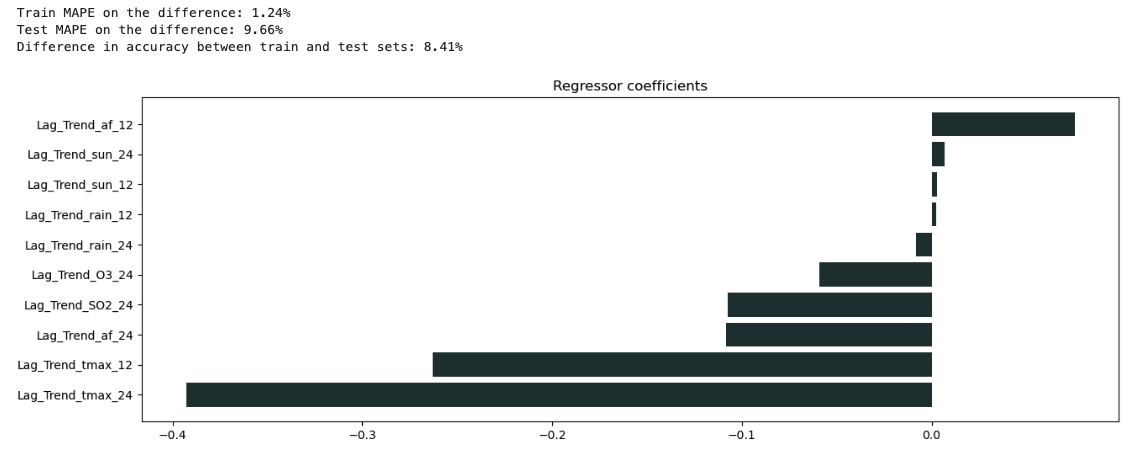

__COMMENT:__ The results are much improved! I will try to improve the model a bit more with dropping the columns :

- which have the lowest regressor values
- Also dropping af24 which proved to be harder to predict in the forecasts section

In [65]:
full_df_multi_lags2 = full_df_multi_lags.drop(columns=['Lag_Trend_rain_12', 'Lag_Trend_sun_12', 'Lag_Trend_af_24'])

In [66]:
################ Finding Best Parameters ################
value_seasonality = [0.001, 0.01, 0.1, 1, 10, 100]
value_changepoint = [0.001, 0.01, 0.1, 1, 10, 100]

multi_params_prophet(full_df_multi_lags2, value_seasonality, value_changepoint)

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


Minimum MAPE test value: 8.81 

    Value_s  Value_c  MAPE_train  MAPE_test  Diff_MAPE
27     10.0      1.0    1.238422    8.81216   7.573739

seasonality_prior_scale value for minimum MAPE test: 10.0
changepoint_prior_scale value for minimum MAPE test: 1.0


In [99]:
################ Model and evalutation ################
# multi_prophet(full_df_multi_lags2, 10, 1, '- Lags and variables selection #2')

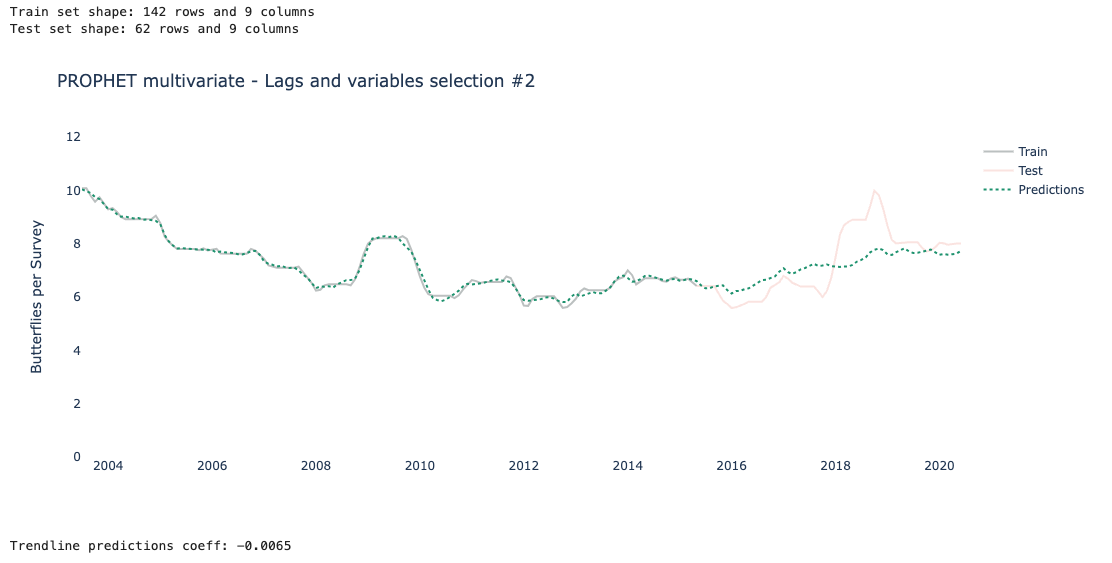
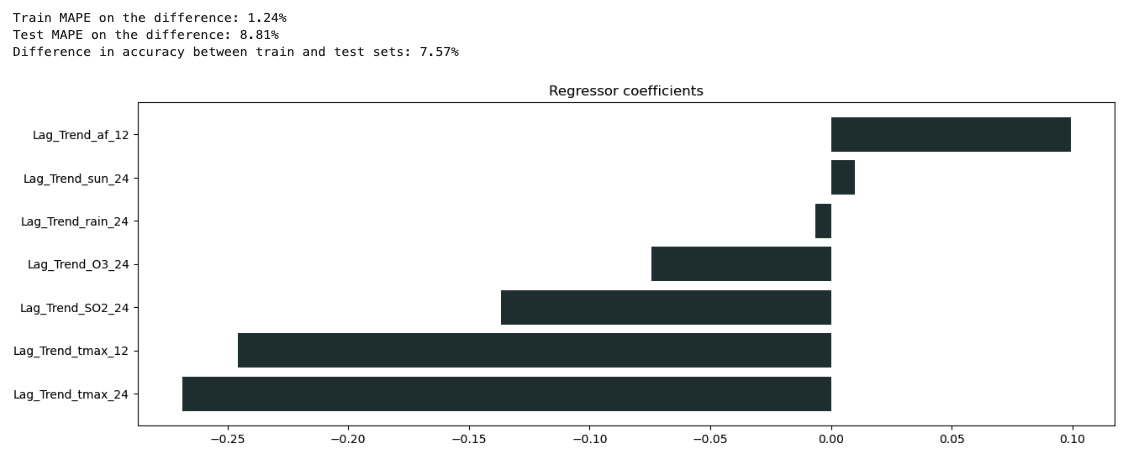

__COMMENT:__ The model has been improved to a 8.81% MAPE score on the test set! Apart from the metric, we can also see that the predictions line on the plot nicely follows the test set, even if it is not capturing 100% of the fluctuations. The test set is increasing up until 2018 and then decreasing and kind of stagnate up until 2020, which is also the case of our predictions!

### Evaluation

__COMMENT__: Further to the MAPE scores, we will get a closer look on the model performance using cross-validation and residuals analysis.

Train set shape: 142 rows and 9 columns
Test set shape: 62 rows and 9 columns


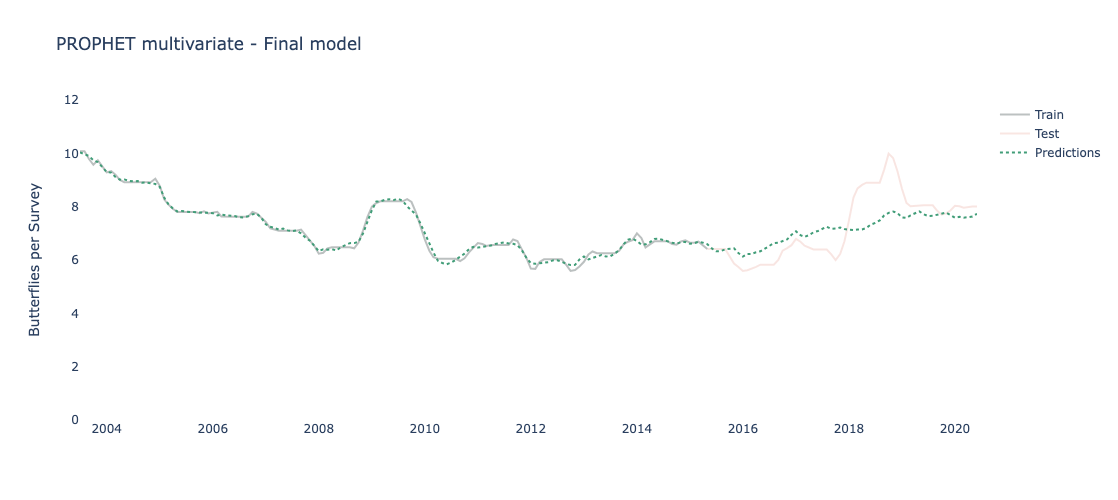

Trendline predictions coeff: -0.0065


Train MAPE on the difference: 1.24%
Test MAPE on the difference: 8.81%
Difference in accuracy between train and test sets: 7.57% 



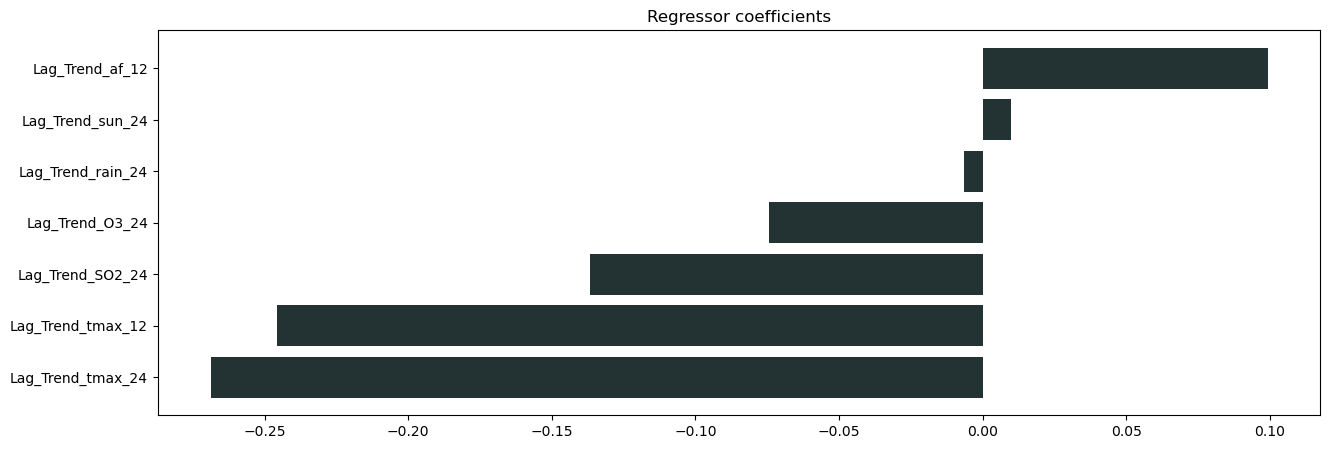

In [98]:
### Reinstantiate model 4, out of the function, to be able to use the variables it in this section

# Instantiate the model
model_final = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, 
                holidays=None, seasonality_prior_scale=10, changepoint_prior_scale=1)

# Add regressors (independant variables)
for col in full_df_multi_lags2.drop(columns=['y', 'ds']).columns:
    model_final.add_regressor(col)

# Train/test Split - Defining % of data points in the test sets (30%)
nobs = int(len(full_df_multi_lags2)*0.70)

# Creating train and test sets
train = full_df_multi_lags2.iloc[:nobs,:]
print(f'Train set shape: {train.shape[0]} rows and {train.shape[1]} columns')

test = full_df_multi_lags2.iloc[nobs:,:]
print(f'Test set shape: {test.shape[0]} rows and {test.shape[1]} columns')

# Fit the Model
prophet_fit_multi = model_final.fit(train)

# Model predictions
future_multi = model_final.make_future_dataframe(periods=len(test), freq='MS')
full_future_multi = pd.merge(future_multi, full_df_multi_lags2.drop(columns=['y']), left_on='ds', right_on='ds', how='left')
forecast_multi = model_final.predict(full_future_multi)

# Make sure no predictions is below 0 (not possible)
forecast_multi['yhat'] = np.where(forecast_multi['yhat']<0, 0, forecast_multi['yhat'])

# Merge dataset and forecast
observed_forecast_prophet_multi = pd.merge(full_df_multi_lags2, forecast_multi, left_on='ds', right_on='ds', how='left')

# Add Order info for linear regression
observed_forecast_prophet_multi['Order'] = range(len(observed_forecast_prophet_multi))

#Get Trendline
X = observed_forecast_prophet_multi['Order']
y = observed_forecast_prophet_multi['yhat']
Trendline = sm.OLS(y.values, sm.add_constant(X.values), missing='drop').fit()

# Plotting True values and Predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=observed_forecast_prophet_multi.loc[:nobs,'ds'], 
                         y=observed_forecast_prophet_multi.loc[:nobs,'y'], 
                         mode='lines', line=dict(color='#233333'), name='Train', opacity=0.3))
fig.add_trace(go.Scatter(x=observed_forecast_prophet_multi.loc[nobs:,'ds'], 
                         y=observed_forecast_prophet_multi.loc[nobs:,'y'], 
                         mode='lines', line=dict(color='#EBACA0'), name='Test', opacity=0.3))
fig.add_trace(go.Scatter(x=observed_forecast_prophet_multi['ds'],
                         y=observed_forecast_prophet_multi['yhat'], mode='lines', 
                         line_dash='dot', line=dict(color='#419D78'), name='Predictions'))

fig.update_yaxes(range=[0, 12])
fig.update_layout(yaxis_title='Butterflies per Survey', 
                      title=f'PROPHET multivariate - Final model',
                      width=1100, height=500, plot_bgcolor='white', showlegend=True)

fig.show()

print(f'Trendline predictions coeff: {round(Trendline.params[1],4)}')
print('\n')

# Evaluation MAPE
train_mape = mean_absolute_percentage_error(observed_forecast_prophet_multi.loc[:nobs,'y'], 
                                            observed_forecast_prophet_multi.loc[:nobs,'yhat'])
test_mape = mean_absolute_percentage_error(observed_forecast_prophet_multi.loc[nobs:,'y'], 
                                           observed_forecast_prophet_multi.loc[nobs:,'yhat'])
Diff_MAPE = Diff_MAPE_calculation(train_mape, test_mape)

print(f'Train MAPE on the difference: {round(train_mape, 2)}%')
print(f'Test MAPE on the difference: {round(test_mape, 2)}%')
print(f'Difference in accuracy between train and test sets: {round(Diff_MAPE, 2)}% \n')

# Plotting regressors coefs
regressor_coef = regressor_coefficients(model_final)
regressor_coef = regressor_coef.sort_values(by='coef', ascending=True)

plt.figure(figsize=(15,5))
plt.barh(regressor_coef['regressor'], regressor_coef['coef'], color='#233333')
plt.title('Regressor coefficients')
plt.show()

In [69]:
# Cross validation over 5-year windows, starting after 3 years of data
# val = cross_validation(model_final, initial = '1095 days', period = '365 days', horizon= '1895 days', parallel='processes')
# df_p = performance_metrics(val)
# fig = plot_cross_validation_metric(val, metric='mape', color='#233333', point_color='#233333', figsize=(8,4))
# fig.show()

## Image here: 

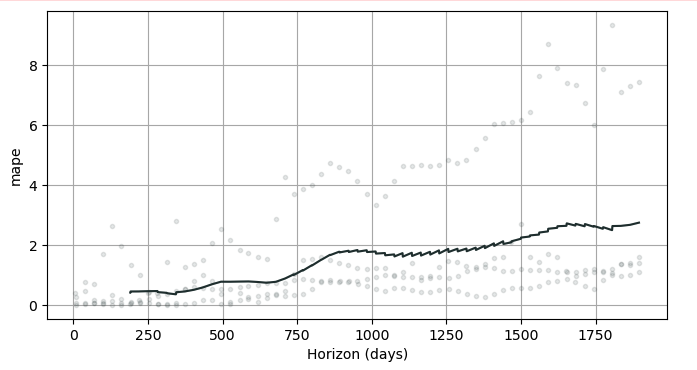

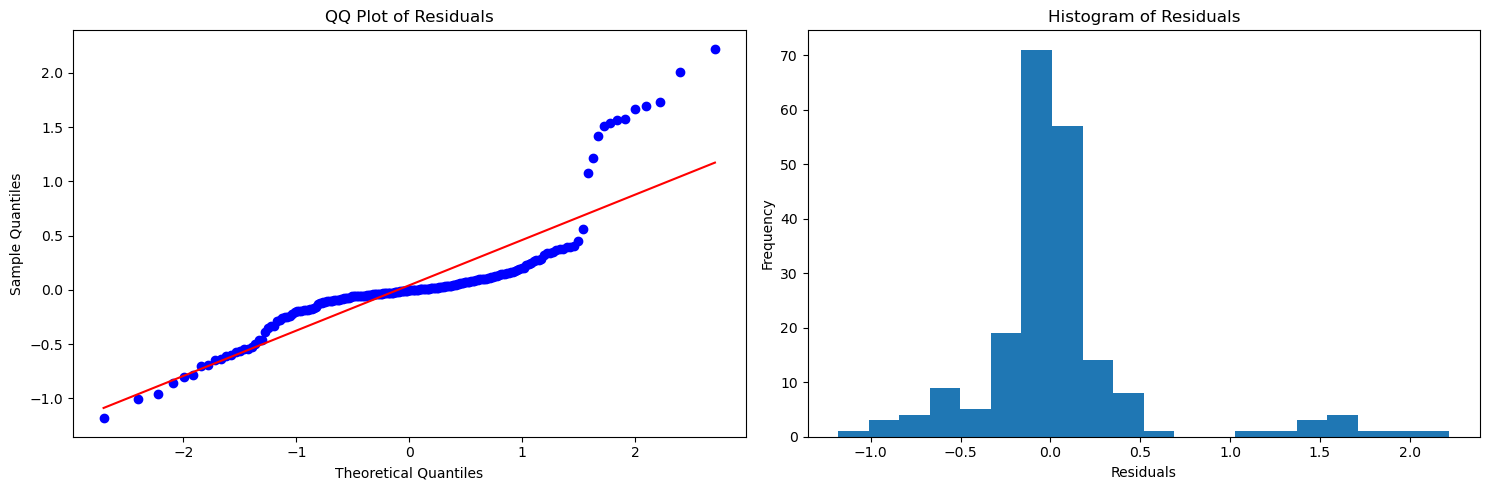

In [70]:
# Checking for the distribution of the residuals
residuals = observed_forecast_prophet_multi['y'] - observed_forecast_prophet_multi['yhat']

plt.subplots(1,2, figsize=(15,5))

plt.subplot(1,2,1)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.subplot(1,2,2)
plt.hist(residuals, bins=20)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [71]:
# Checking where the highest residuals values are 
residuals_df = pd.DataFrame(data=residuals.to_list(), columns= ['residuals'], index=observed_forecast_prophet_multi['ds'])
residuals_df.sort_values(by='residuals', ascending=False).head(10)

,residuals
ds,
2018-10-01,2.220739
2018-11-01,2.005291
2018-09-01,1.727320
2018-05-01,1.695412
2018-04-01,1.669519
2018-06-01,1.570120
2018-12-01,1.567634
2018-03-01,1.540033
2018-07-01,1.509261


__COMMENT:__ Further investigation of the model reveals that:

- __Cross validation analysis__: The model is able to predict quite nicely over a 1 year period (up to around 6 months with strong accuracy, and good accuracy afterwards). The results are less accurate after 1 year.
- __Residuals distribution__: The residuals are a bit skewed

Those results are actually not surprising: the highest points in the residuals mainly represent the peak in 2018 which the model failed to predict the importance of. 

My conclusion would therefore be that the model will not be able to predict the next exact values with a strong accuracy, however the general trend and variations have been nicely captured. The purpose of the analysis being: *understanding the general trend and forces at work*, my conclusion is that this has been achieved with:
- 8% MAPE on test set - a good score
- the trend of the predictions which nicely follows the general trend

# Forecasts

__COMMENT:__ In this section I will explore forecasting the Butterfly population evolution from 2020 to 2024 (aka 4 years after the and of the initial dataset). To do that I will:

- Create forecasts for each single external factors using a univariate Prophet model for each.
- Combine all forecasts together and create a dataset with:
    - Butterflies: actual values from 2001 to 2020
    - External factors: actual values from 2001 to 2020 and forecasted values from 2020 to 2024
- Use model 4 to predict the Butterflies per Survey values from 2020 to 2024

Then, I will manually tweak the external factor predictions from 2020 to 2024 to simulate the impact of external factors on the butterflies, for example: if the temperatures are 10% higher than what we anticipate, how the butterfly population is likely to respond?

## Univariate models for external factors

In [72]:
# Isolating the values of each external factor selected by the model in several dataframes
df_list = []

for col in full_df_multi_lags2.drop(columns=['y', 'ds']):
    df_list.append(pd.DataFrame(data = full_df_multi_lags2[col].values, index = full_df_multi_lags2['ds'], columns = ['y']).reset_index())

df_tmax_12, df_tmax_24, df_af_12, df_rain_24, df_sun_24, df_O3_24, df_SO2_24 = [i for i in df_list]

### tmax12

In [73]:
################ Finding Best Parameters ################
value_seasonality = [0.001, 0.01, 0.1, 1, 10, 100]
value_changepoint = [0.001, 0.01, 0.1, 1, 10, 100]

uni_params_prophet(df_tmax_12, value_seasonality, value_changepoint)

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


Minimum MAPE test value: 1.62 

    Value_s  Value_c  MAPE_train  MAPE_test  Diff_MAPE
3     0.001      1.0     1.78407   1.617208   0.166862
9     0.010      1.0     1.78407   1.617208   0.166862
15    0.100      1.0     1.78407   1.617208   0.166862
21    1.000      1.0     1.78407   1.617208   0.166862
27   10.000      1.0     1.78407   1.617208   0.166862
33  100.000      1.0     1.78407   1.617208   0.166862

seasonality_prior_scale value for minimum MAPE test: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
changepoint_prior_scale value for minimum MAPE test: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


__COMMENT:__ We show here :

- First, what the uni_prophet_forecast function is doing
- Secondly, we pass the function to create the dataframe, as with all next variables (tmax24, af12...)

In [74]:
#### Code in the uni_prophet_forecast function - just to make it easier to read the notebook
# Instantiate the model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, 
                holidays=None, seasonality_prior_scale=0.001, changepoint_prior_scale=1)

# Train/test Split - Defining % of data points in the test sets (30%)
nobs = int(len(df_tmax_12)*0.70)

# Fit the Model
model.fit(df_tmax_12)

# Model predictions
future = model.make_future_dataframe(periods=60, freq='MS')
forecast = model.predict(future)

# Make sure no predictions is below 0 (not possible)
forecast['yhat'] = np.where(forecast['yhat']<0, 0, forecast['yhat'])

# Merge dataset and forecast
observed_forecast = pd.merge(df_tmax_12, forecast, left_on='ds', right_on='ds', how='right')

# Create df with y and yhat values for multivariate predictions
index_split = df_tmax_12.index[-1]
observed_forecast = observed_forecast[['ds', 'y', 'yhat']]
observed_forecast.loc[index_split:,'y'] = observed_forecast.loc[index_split:,'yhat']
observed_forecast = observed_forecast['y'].to_list()

In [75]:
################ Create forecasts ################
tmax12_forecast = uni_prophet_forecast(df_tmax_12, 0.001, 1)

### tmax24

In [76]:
################ Finding Best Parameters ################
value_seasonality = [0.001, 0.01, 0.1, 1, 10, 100]
value_changepoint = [0.001, 0.01, 0.1, 1, 10, 100]

uni_params_prophet(df_tmax_24, value_seasonality, value_changepoint)

Minimum MAPE test value: 5.18 

    Value_s  Value_c  MAPE_train  MAPE_test  Diff_MAPE
0     0.001    0.001    2.471076   5.183447   2.712371
6     0.010    0.001    2.471076   5.183447   2.712371
12    0.100    0.001    2.471076   5.183447   2.712371
18    1.000    0.001    2.471076   5.183447   2.712371
24   10.000    0.001    2.471076   5.183447   2.712371
30  100.000    0.001    2.471076   5.183447   2.712371

seasonality_prior_scale value for minimum MAPE test: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
changepoint_prior_scale value for minimum MAPE test: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


In [77]:
################ Create forecasts ################
tmax24_forecast = uni_prophet_forecast(df_tmax_24, 0.001, 0.001)

### af12

In [78]:
################ Finding Best Parameters ################
value_seasonality = [0.001, 0.01, 0.1, 1, 10, 100]
value_changepoint = [0.001, 0.01, 0.1, 1, 10, 100]

uni_params_prophet(df_af_12, value_seasonality, value_changepoint)

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


Minimum MAPE test value: 48.98 

    Value_s  Value_c  MAPE_train  MAPE_test  Diff_MAPE
2     0.001      0.1   39.322324  48.984368   9.662044
8     0.010      0.1   39.322324  48.984368   9.662044
14    0.100      0.1   39.322324  48.984368   9.662044
20    1.000      0.1   39.322324  48.984368   9.662044
26   10.000      0.1   39.322324  48.984368   9.662044
32  100.000      0.1   39.322324  48.984368   9.662044

seasonality_prior_scale value for minimum MAPE test: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
changepoint_prior_scale value for minimum MAPE test: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


Train set shape: 142 rows and 2 columns
Test set shape: 62 rows and 2 columns


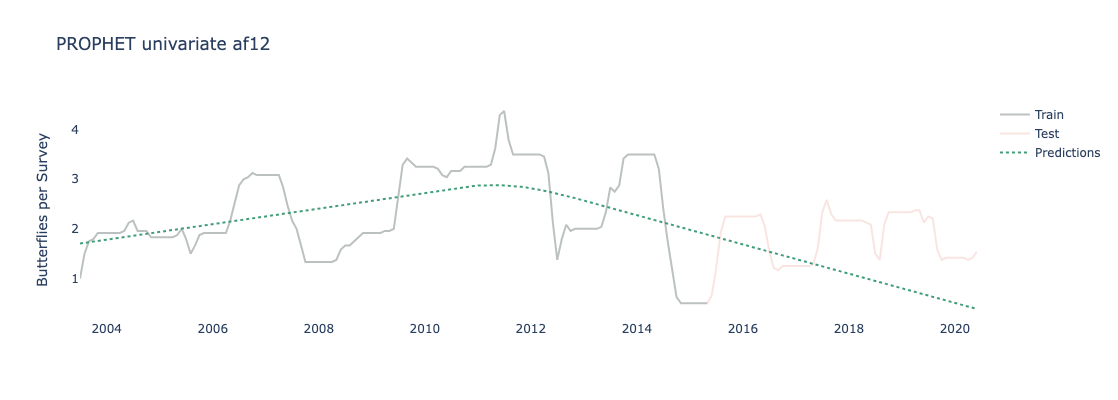

Trendline predictions coeff: -0.0069


Train MAPE on the difference: 39.32%
Test MAPE on the difference: 48.98%
Difference in accuracy between train and test sets: 9.66% 



In [79]:
## The scores are higher here, checking the plots if that makes sense
uni_prophet(df_af_12, 0.001, 0.1, 'af12')

In [80]:
# The predictions make sense, proceeding
################ Create forecasts ################
af12_forecast = uni_prophet_forecast(df_af_12, 0.001, 0.1)

### rain24

In [81]:
################ Finding Best Parameters ################
value_seasonality = [0.001, 0.01, 0.1, 1, 10, 100]
value_changepoint = [0.001, 0.01, 0.1, 1, 10, 100]

uni_params_prophet(df_rain_24, value_seasonality, value_changepoint)

Minimum MAPE test value: 11.5 

    Value_s  Value_c  MAPE_train  MAPE_test  Diff_MAPE
2     0.001      0.1   13.166548  11.497525   1.669023
8     0.010      0.1   13.166548  11.497525   1.669023
14    0.100      0.1   13.166548  11.497525   1.669023
20    1.000      0.1   13.166548  11.497525   1.669023
26   10.000      0.1   13.166548  11.497525   1.669023
32  100.000      0.1   13.166548  11.497525   1.669023

seasonality_prior_scale value for minimum MAPE test: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
changepoint_prior_scale value for minimum MAPE test: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


In [82]:
################ Create forecasts ################
rain24_forecast = uni_prophet_forecast(df_rain_24, 0.001, 0.1)

### sun24

In [83]:
# ################ Finding Best Parameters ################
value_seasonality = [0.001, 0.01, 0.1, 1, 10, 100]
value_changepoint = [0.001, 0.01, 0.1, 1, 10, 100]

uni_params_prophet(df_sun_24, value_seasonality, value_changepoint)

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


Minimum MAPE test value: 10.72 

    Value_s  Value_c  MAPE_train  MAPE_test  Diff_MAPE
1     0.001     0.01   17.359318  10.721102   6.638216
7     0.010     0.01   17.359318  10.721102   6.638216
13    0.100     0.01   17.359318  10.721102   6.638216
19    1.000     0.01   17.359318  10.721102   6.638216
25   10.000     0.01   17.359318  10.721102   6.638216
31  100.000     0.01   17.359318  10.721102   6.638216

seasonality_prior_scale value for minimum MAPE test: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
changepoint_prior_scale value for minimum MAPE test: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]


In [84]:
################ Create forecasts ################
sun24_forecast = uni_prophet_forecast(df_sun_24, 0.001, 0.01)

### O3 24

In [85]:
################ Finding Best Parameters ################
value_seasonality = [0.001, 0.01, 0.1, 1, 10, 100]
value_changepoint = [0.001, 0.01, 0.1, 1, 10, 100]

uni_params_prophet(df_O3_24, value_seasonality, value_changepoint)

Minimum MAPE test value: 11.71 

    Value_s  Value_c  MAPE_train  MAPE_test  Diff_MAPE
1     0.001     0.01     5.39623  11.708238   6.312008
7     0.010     0.01     5.39623  11.708238   6.312008
13    0.100     0.01     5.39623  11.708238   6.312008
19    1.000     0.01     5.39623  11.708238   6.312008
25   10.000     0.01     5.39623  11.708238   6.312008
31  100.000     0.01     5.39623  11.708238   6.312008

seasonality_prior_scale value for minimum MAPE test: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
changepoint_prior_scale value for minimum MAPE test: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]


In [86]:
################ Create forecasts ################
O3_24_forecast = uni_prophet_forecast(df_O3_24, 0.001, 0.01)

### SO2 24

In [87]:
################ Finding Best Parameters ################
value_seasonality = [0.001, 0.01, 0.1, 1, 10, 100]
value_changepoint = [0.001, 0.01, 0.1, 1, 10, 100]

uni_params_prophet(df_SO2_24, value_seasonality, value_changepoint)

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


Minimum MAPE test value: 16.35 

    Value_s  Value_c  MAPE_train  MAPE_test  Diff_MAPE
2     0.001      0.1    6.001263  16.352639  10.351376
8     0.010      0.1    6.001263  16.352639  10.351376
14    0.100      0.1    6.001263  16.352639  10.351376
20    1.000      0.1    6.001263  16.352639  10.351376
26   10.000      0.1    6.001263  16.352639  10.351376
32  100.000      0.1    6.001263  16.352639  10.351376

seasonality_prior_scale value for minimum MAPE test: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
changepoint_prior_scale value for minimum MAPE test: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


In [88]:
################ Create forecasts ################
SO2_24_forecast = uni_prophet_forecast(df_SO2_24, 0.001, 0.1)

### All univariate forecasts

In [89]:
# Combine all external factors forecasts together
forecast_df = pd.DataFrame(index=forecast['ds'])
forecast_df = forecast_df.assign(Lag_Trend_tmax_12 = tmax12_forecast, 
                                 Lag_Trend_tmax_24 = tmax24_forecast, 
                                 Lag_Trend_af_12 = af12_forecast, 
                                 Lag_Trend_rain_24 = rain24_forecast, 
                                 Lag_Trend_sun_24 = sun24_forecast, 
                                 Lag_Trend_O3_24 = O3_24_forecast, 
                                 Lag_Trend_SO2_24 = SO2_24_forecast)
forecast_df = forecast_df.reset_index()
forecast_df.head()

,ds,Lag_Trend_tmax_12,Lag_Trend_tmax_24,Lag_Trend_af_12,Lag_Trend_rain_24,Lag_Trend_sun_24,Lag_Trend_O3_24,Lag_Trend_SO2_24
0,2003-07-01,15.679167,15.125000,1.000000,57.766667,52.5000,14.429326,12.426427
1,2003-08-01,15.495833,15.312500,1.500000,56.525000,51.0625,14.690943,12.278413
2,2003-09-01,15.425000,15.520833,1.750000,53.887500,48.2375,14.903164,12.022649
3,2003-10-01,15.475000,15.762500,1.791667,50.312500,44.7000,15.048934,11.919621
4,2003-11-01,15.512500,15.820833,1.916667,50.825000,46.6250,14.952657,11.813849


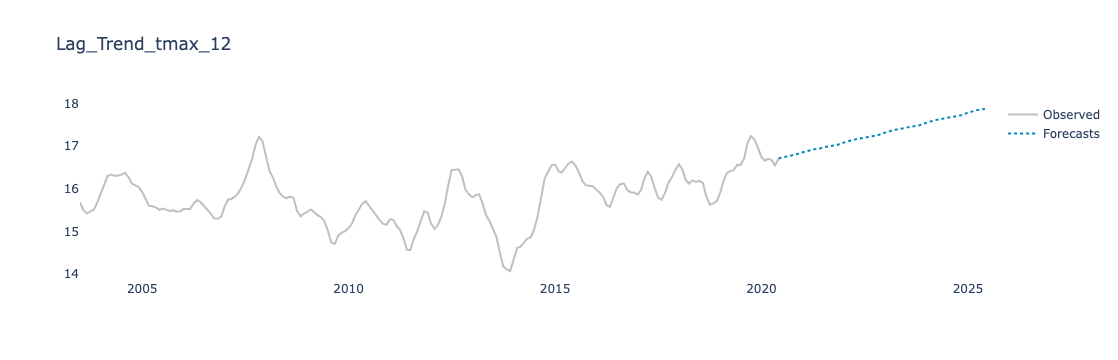

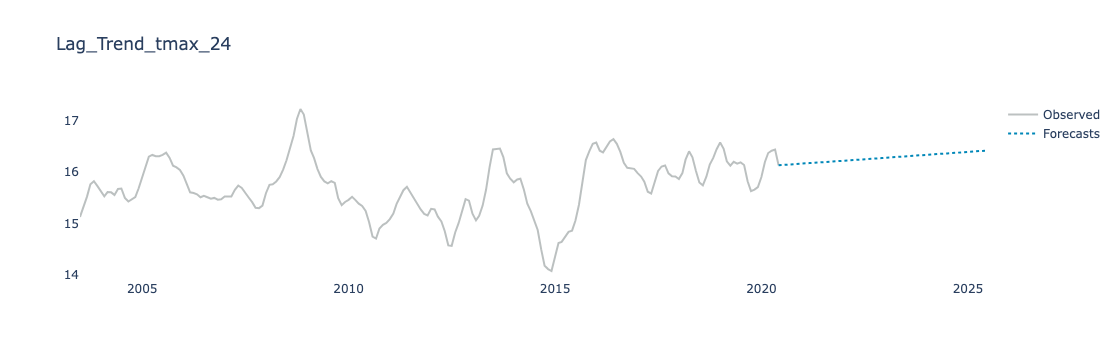

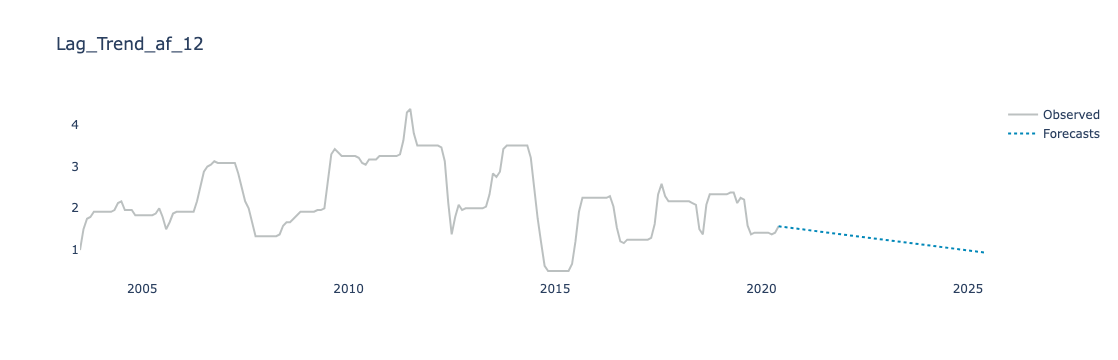

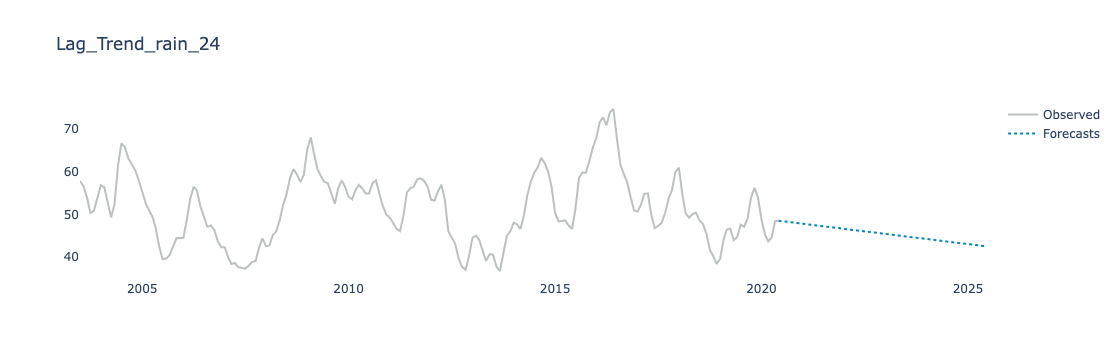

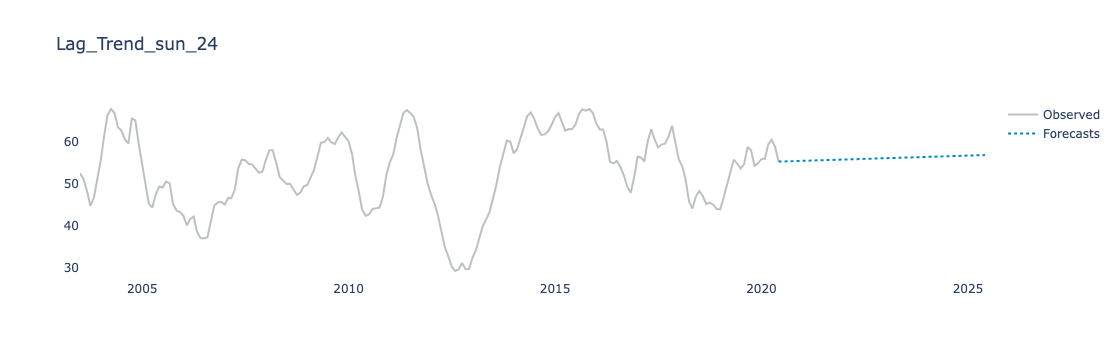

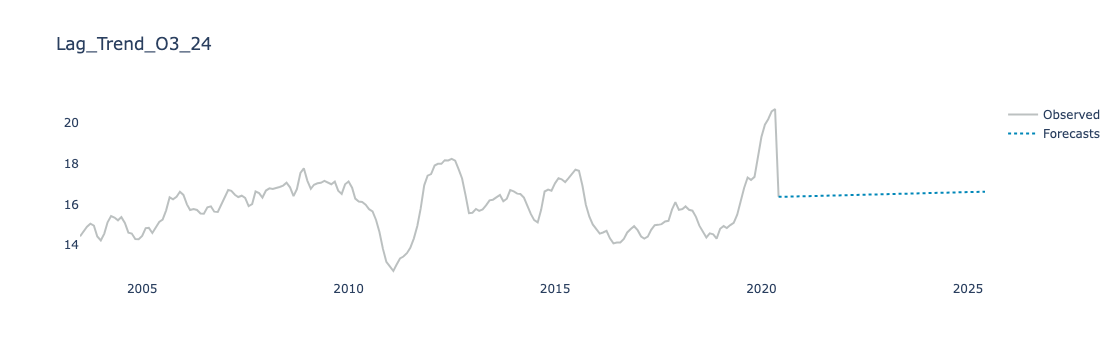

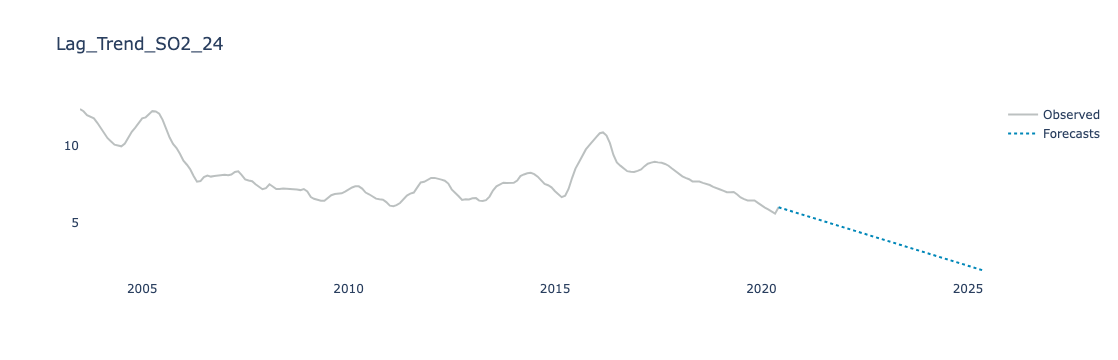

In [90]:
# Checking the forecasts visually
for col in forecast_df.drop(columns=['ds']).columns:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=forecast_df.loc[:index_split,'ds'], 
                             y=forecast_df.loc[:index_split,col], 
                             mode='lines', line=dict(color='#233333'), name='Observed', opacity=0.3))
    fig.add_trace(go.Scatter(x=forecast_df.loc[index_split:, 'ds'],
                             y=forecast_df.loc[index_split:, col], mode='lines', 
                             line_dash='dot', line=dict(color='#0087B8'), name='Forecasts'))
        
    fig.update_layout(title=f'{col}', width=1100, height=300, plot_bgcolor='white', showlegend=True)
    fig.show()

## Butterflies per Survey forecasts

__COMMENT:__ I explore here 2 simulations:

- Forecasts if the values of external factors evolve as they are expected from last data points recorded
- Forecasts if the values of temperatures are 10% higher than expected

Other simulations can be done on the Streamlit app.

### 'As is' preds

In [91]:
### Prep dataset
forecast_df = pd.merge(forecast_df, full_df_multi_lags2[['y', 'ds']], left_on='ds', right_on='ds', how='left')
forecast_df.tail()

,ds,Lag_Trend_tmax_12,Lag_Trend_tmax_24,Lag_Trend_af_12,Lag_Trend_rain_24,Lag_Trend_sun_24,Lag_Trend_O3_24,Lag_Trend_SO2_24,y
259,2025-02-01,17.816397,16.397813,0.982463,42.967625,56.721522,16.608177,2.106612,NaN
260,2025-03-01,17.834924,16.402475,0.972838,42.875394,56.747548,16.611976,2.042827,NaN
261,2025-04-01,17.854056,16.406504,0.962208,42.771669,56.775110,16.617270,1.972005,NaN
262,2025-05-01,17.869228,16.410422,0.951982,42.674054,56.800672,16.623337,1.902524,NaN
263,2025-06-01,17.875162,16.416676,0.941482,42.576322,56.825633,16.629219,1.831220,NaN


Train set shape: 142 rows and 9 columns
Test set shape: 62 rows and 9 columns


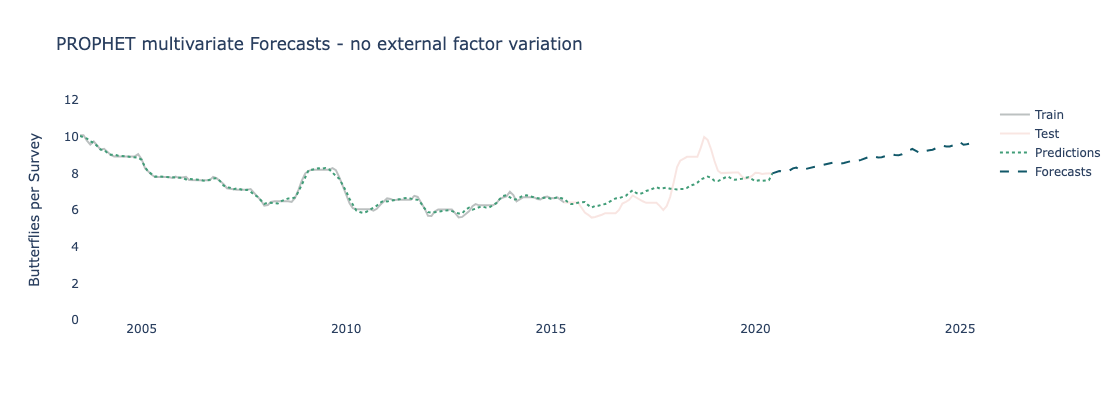

In [92]:
################ Model and evalutation ################
multi_prophet_forecast(forecast_df, 10, 1, 'Forecasts - no external factor variation')

### +10% temp scenario

In [93]:
### Prep dataset
forecast_df_p10tmax = forecast_df.copy()

# Add 10 % to tmax predictions (2020-06-01 = last observed value available)
forecast_df_p10tmax.loc['2020-06-01':,'Lag_Trend_tmax_12'] = forecast_df_p10tmax.loc['2020-06-01':,'Lag_Trend_tmax_12'].mul(1.1)
forecast_df_p10tmax.loc['2020-06-01':,'Lag_Trend_tmax_24'] = forecast_df_p10tmax.loc['2020-06-01':,'Lag_Trend_tmax_24'].mul(1.1)
forecast_df_p10tmax.head(3)

,ds,Lag_Trend_tmax_12,Lag_Trend_tmax_24,Lag_Trend_af_12,Lag_Trend_rain_24,Lag_Trend_sun_24,Lag_Trend_O3_24,Lag_Trend_SO2_24,y
0,2003-07-01,15.679167,15.125000,1.00,57.766667,52.5000,14.429326,12.426427,10.080100
1,2003-08-01,15.495833,15.312500,1.50,56.525000,51.0625,14.690943,12.278413,10.080100
2,2003-09-01,15.425000,15.520833,1.75,53.887500,48.2375,14.903164,12.022649,9.788433


Train set shape: 142 rows and 9 columns
Test set shape: 62 rows and 9 columns


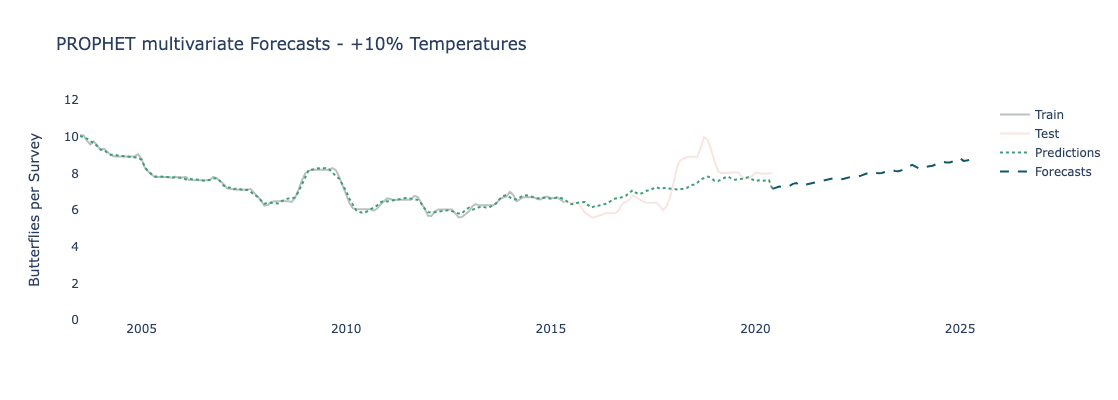

In [94]:
################ Model and evalutation ################
multi_prophet_forecast(forecast_df_p10tmax, 10, 1, 'Forecasts - +10% Temperatures')

__COMMENT:__ the butterfly per survey is lower here (8.83 in June 2025) than is the first simulation (9.71 in June 2025).


More simulations can be done on the streamlit app.